<a href="https://colab.research.google.com/github/edofiorini/mobile-Anomaly-Detection/blob/main/anomaly_detection_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title import
import torch
import torch.nn as nn
import numpy, math
import matplotlib.pyplot as plt
import matplotlib
import collections
import seaborn as sn
from tqdm import tqdm
from torch.nn.utils import weight_norm
from sklearn import preprocessing, metrics, svm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.ndimage.interpolation import shift
from fastai.tabular import *
from collections import Counter
from google.colab import drive
from datetime import datetime
from fastai.imports import *
from abc import ABCMeta, abstractmethod
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import scale
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#@title pip
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

In [ ]:
#@title Utility
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'prove/'
img_dir = base_dir + 'img/'
log_dir = base_dir + 'log/'
dump_dir = base_dir + 'dump/'
model_dir = base_dir + 'models/'
dset_dir = base_dir + 'dset/'
root_path = Path(root_dir)
base_path = Path(base_dir)
model_path = Path(model_dir)
img_path = Path(img_dir)
log_path = Path(log_dir)
dump_path = Path(dump_dir)
dset_path = Path(dset_dir)

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

def get_sin(dim,f,a,p):
  return [np.sin(i/f+p)*a for i in range(0,dim)]

#solo per fastAI
def expandDf(df, time):
  lags = range(1, time)
  df = df.assign(**{
      '{} (t-{})'.format(col, t): df[col].shift(t)
      for t in lags
      for col in df
  })
  df = df.fillna(0)
  return df.iloc[time-1:]

def expandNames(names, time):
  ris = names.copy()
  for i in range(1,time):
    for name in names:
      ris.append(str(name+' (t-'+str(i)+')'))
  return ris

def mse(x_hat, x): return ((x_hat-x)**2).mean()

#sigmoid for np vector
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

#new
def split_sequence(sequenceX, n_steps, sequenceY=None, y_all=False, shiftY=True, approx=1):
  if shiftY:
    shift = 1
  else:
    shift = 0
  if sequenceY is None:
    sequenceY = sequenceX
  X, y = list(), list()
  for i in range(int(len(sequenceX)/approx)):
    # find the end of this pattern
    i = i * approx
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequenceX)-shift:
      break
    # gather input and output parts of the pattern
    seq_x = sequenceX[i:end_ix]
    if y_all:
      seq_y = sequenceY[i+shift:end_ix+shift]
    else:
      seq_y = sequenceY[end_ix+shift-1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)


def normalize(dfToNorm, dfBase):
    result = dfToNorm.copy()
    for feature_name in dfBase.columns:
      max_value = dfBase[feature_name].max()
      min_value = dfBase[feature_name].min()
      result[feature_name] = ((dfToNorm[feature_name] - min_value) / (max_value - min_value)) *2 - 1

      result.replace([np.inf, -np.inf], np.nan,inplace=True)
      result = result.fillna(0) #se una colonna ha valori costanti -> NaN -> sostituzione con 0
    return result

def standardize(dfToNorm, dfBase):
    result = dfToNorm.copy()
    for feature_name in dfBase.columns:
      std_value = dfBase[feature_name].std()
      mean_value = dfBase[feature_name].mean()
      result[feature_name] = (dfToNorm[feature_name] - mean_value) / std_value
      
      result.replace([np.inf, -np.inf], np.nan,inplace=True)
      result = result.fillna(0) #se una colonna ha valori costanti -> NaN -> sostituzione con 0
    return result

#crea un df prendendo da quello in input per ogni colonna max e min
def crateRandomDf(df, dim, normal=True):
    result = pd.DataFrame()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        std_value = df[feature_name].std()
        mean_value = df[feature_name].mean()
        if normal:
          result[feature_name] = np.random.normal(mean_value,std_value,size=dim)
        else:
          result[feature_name] = np.random.random_sample(dim) * (max_value-min_value) + min_value
        
        result = result.fillna(0) #se una colonna ha valori costanti -> NaN -> sostituzione con 0
    return result

#aggiunge a panda la possibilita di prendere un blocco contiguo di lung num
def sampleBlock(self, num=1, remove=False):
  if num>len(self):
    raise Exception('block should not exceed len(df). The value of num was: {}'.format(num))
  min = random.randint(0,len(self)-num)
  select = self.iloc[min:min+num].copy()
  if remove:
    df = self.drop(list(range(min,min+num)))
    df = df.reset_index(drop=True)
    return select, df
  return select
setattr(pd.core.frame.DataFrame, "sampleBlock", sampleBlock)

#semplice funzione per stampare i tempi di esecuzione
import time
printTime_seconds = time.time()
printTime_interval = time.time()
def printTime():
  global printTime_seconds, printTime_interval
  print(time.time()-printTime_interval,'-', time.time()-printTime_seconds)
  printTime_interval = time.time()

  
import re
import ipaddress
expression_ipv4 = '([0-9]+\.[0-9]+\.[0-9]+\.[0-9]+)'
expression_ipv6 = '([0-9a-f]+:[0-9a-f]+:[0-9a-f]+:[0-9a-f]+:[0-9a-f]+:[0-9a-f]+:[0-9a-f]+:[0-9a-f]+(%[a-zA-Z0-9]+)?)'
def ip2int(x):
  mv4 = re.search(expression_ipv4, x)
  mv6 = re.search(expression_ipv6, x)
  if mv4:
    return int(ipaddress.IPv4Address(mv4.group(0)))
  if mv6:
    return int(ipaddress.IPv4Address(mv6.group(0)))
  return 0

def myShift(data):
  if len(data.shape)==2:
    return np.append(numpy.delete(data,[0], axis=0), [np.zeros(data.shape[1])], axis=0)
  else:
    return np.append(numpy.delete(data,[0], axis=0), np.zeros(1), axis=0)

def printRisTab(name,row,mode):
  if mode == 'over%': mode = 'FO'
  if mode == 'overRange%': mode = 'FR'
  if mode == 'overNum': mode = 'NO'
  if mode == 'overRangeNum': mode = 'NR'
  if mode == 'O': mode = 'NO'
  print(name,'\t'.join('{}'.format(v) for k,v in row.items() if mode in k), sep='\t')
  #print(name,ris[name]['precision'],ris[name]['recall'],ris[name]['normal'], '\t'.join('{}'.format(v) for k,v in ris[name]['attack'].items()), sep='\t')

def distrInDic(df_dic_len,p):
  ris = {}
  inc = 0
  for nome, d in df_dic_len.items():
    ris[nome] = p[inc:inc+d]
    inc += d
  return ris

def distrInDicDfByIndex(df_dic_len,p,inc):
  ris = {}
  for nome, d in df_dic_len.items():
    ris[nome] = p.loc[inc:inc+d]
    inc += d
  return ris

def derivateDf(df):
  for colName in df:
    df[colName] = np.convolve(df[colName], [1, -1])[:-1]
  return df

def addDerivateDf(df):
  cols = df.columns.values.tolist()
  newDf = df.copy()
  for col in cols:
    #print(col+'_der')
    newDf[col+'_der'] = pd.Series(np.convolve(df[col], [1, -1])[:-1], index=df.index)
  return newDf

def splitPreds(ds, preds, round=False, windowSize=0):
  #dfL, dfT, dfA = dfL_len, dfT_len, dfA_len
  dfL, dfT, dfA, dfA_dic = ds.getDfLen(round=round)
  dfL -= windowSize
  dfT -= windowSize
  dfA -= windowSize
  #print(dfL, dfT, dfA, dfA_dic)
  #fixme: dfL_dic['Normal'] -> dfL
  pL = preds[0:dfL]
  pT = preds[dfL:dfL+dfT]
  pA = preds[dfL+dfT:dfL+dfT+dfA]
  #pL_dic = distrInDic(dfL_dic,pL)
  pA_dic = distrInDic(dfA_dic,pA)
  return pL, pT, pA, pA_dic

#come sopra ma se passo un df con gli indici usa quelli per dividere
def splitPredsDfByIndex(ds, preds, round=False, windowSize=0):
  #dfL, dfT, dfA = dfL_len, dfT_len, dfA_len
  dfL, dfT, dfA, dfA_dic = ds.getDfLen(round=round)
  dfL -= windowSize
  dfT -= windowSize
  dfA -= windowSize
  #print(dfL, dfT, dfA, dfA_dic)
  #fixme: dfL_dic['Normal'] -> dfL
  pL = preds.loc[0:dfL]
  pT = preds.loc[dfL:dfL+dfT]
  pA = preds.loc[dfL+dfT:dfL+dfT+dfA]
  #pL_dic = distrInDicDfByIndex(dfL_dic,pL,0)
  pA_dic = distrInDicDfByIndex(dfA_dic,pA,dfL+dfT)
  return pL, pT, pA, pA_dic

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

def freeMemory():
  torch.cuda.empty_cache()

def printPlotLoss(lossLog, cutStart=0):
  plt.figure(figsize=(20,5))
  for n,d in lossLog.items():
    plt.plot(d[cutStart:], label=n)
  plt.legend()
  plt.ylabel('')
  plt.show()

#One Hot Encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    if isinstance(cols, str): cols = [cols]
    for each in cols:
      dfDummies = pd.get_dummies(pd.Categorical(df[each]), prefix = each)
      df = pd.concat([df, dfDummies], axis=1)
      del df[each]
    return df.copy()

def printDf(df):
  plt.figure(figsize=(30, 5))
  plt.plot(df)
  plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USING DEVICE:", device)

USING DEVICE: cuda


* L: dataset learning (comportamento normale)
* T: test comportamento normale
* A: test comportamento attacco







In [ ]:
#@title Global variables
gv={}
gv['approxValue'] = 1
gv['splitTest'] = 10
gv['savePlot'] = False
gv['log'] = False
gv['model_name'] = str(datetime.now())

#sg: sensor group (original)
gv['sg']={}
gv['sg']['boat']={}
gv['sg']['boat']['num'] = ['proximity', 'step_counter', 'step_detector', 'sensor', 'magnetic_field_uncalibrated']
gv['sg']['boat']['amb'] = ['water_oxygen', 'magnetic_field', 'gravity', 'pressure', 'light']
gv['sg']['boat']['vel'] = ['motor_vel_1', 'accelerometer', 'linear_acceleration', 'accelerometer_uncalibrated', 'gyroscope_uncalibrated', 'rotation_vector', 'motor_vel_0']
gv['sg']['boat']['pos'] = ['gps_speed', 'game_rotation_vector', 'gps_bearing',  'gps_accuracy', 'gps_longitude', 'gyroscope', 'gps_latitude', 'gps_altitude', 'orientation',  'geomagnetic_rotation_vector']
gv['sg']['boat']['net'] = ['net_rec_offset', 'net_send_length', 'net_rec_malformed', 'net_rec_length']
gv['sg']['boat']['time'] = ['gps_time','net_send_tstamp','net_rec_tstamp']
gv['sg']['boat']['big_string'] = ['net_send_payload_encb64', 'net_rec_payload_encb64', 'net_rec_payload_plainb64', 'net_send_payload_plainb64']
gv['sg']['boat']['small_string'] = ['net_rec_address', 'net_send_address','net_rec_port']
gv['sg']['pepper']={}
gv['sg']['pepper']['position_1'] = ['HeadYaw', 'HeadPicth', 'LShoulderPitch', 'LShoulderRoll', 'LElbowYaw', 'LElbowRoll', 'LWristYaw', 'LHand', 'RShoulderPitch', 'RShoulderRoll', 'RElbowYaw', 'RElbowRoll', 'RWristYaw', 'Rhand', 'HipRoll', 'HipPicth', 'KneePicth']
gv['sg']['pepper']['speed'] = [ 'WheelFLSpeed', 'WheelFRSpeed', 'WheelBSpeed']
gv['sg']['pepper']['laser'] = ['LaserR01X', 'LaserR01Y', 'LaserR02X', 'LaserR02Y', 'LaserR03X', 'LaserR03Y', 'LaserR04X', 'LaserR04Y', 'LaserR05X', 'LaserR05Y', 'LaserR06X', 'LaserR06Y', 'LaserR07X', 'LaserR07Y', 'LaserR08X', 'LaserR08Y', 'LaserR09X', 'LaserR09Y', 'LaserR10X', 'LaserR10Y', 'LaserR11X', 'LaserR11Y', 'LaserR12X', 'LaserR12Y', 'LaserR13X', 'LaserR13Y', 'LaserR14X', 'LaserR14Y', 'LaserR15X', 'LaserR15Y', 'LaserF01X', 'LaserF01Y', 'LaserF02X', 'LaserF02Y', 'LaserF03X', 'LaserF03Y', 'LaserF04X', 'LaserF04Y', 'LaserF05X', 'LaserF05Y', 'LaserF06X', 'LaserF06Y', 'LaserF07X', 'LaserF07Y', 'LaserF08X', 'LaserF08Y', 'LaserF09X', 'LaserF09Y', 'LaserF10X', 'LaserF10Y', 'LaserF11X', 'LaserF11Y', 'LaserF12X', 'LaserF12Y', 'LaserF13X', 'LaserF13Y', 'LaserF14X', 'LaserF14Y', 'LaserF15X', 'LaserF15Y', 'LaserF01X.1', 'LaserF01Y.1', 'LaserF02X.1', 'LaserF02Y.1', 'LaserF03X.1', 'LaserF03Y.1', 'LaserF04X.1', 'LaserF04Y.1', 'LaserF05X.1', 'LaserF05Y.1', 'LaserF06X.1', 'LaserF06Y.1', 'LaserF07X.1', 'LaserF07Y.1', 'LaserF08X.1', 'LaserF08Y.1', 'LaserF09X.1', 'LaserF09Y.1', 'LaserL10X', 'LaserL10Y', 'LaserL11X', 'LaserL11Y', 'LaserL12X', 'LaserL12Y', 'LaserL13X', 'LaserL13Y', 'LaserL14X', 'LaserL14Y', 'LaserL15X', 'LaserL15Y', 'LaserShovel01X', 'LaserShovel01Y', 'LaserShovel02X', 'LaserShovel02Y', 'LaserShovel03X', 'LaserShovel03Y', 'LaserVeR01X', 'LaserVeR01Y', 'LaserVeL01X', 'LaserVeL01Y']
gv['sg']['pepper']['sonar'] = [ 'SonarF', 'SonarB']
gv['sg']['pepper']['infraRed'] = ['InfraRedL', 'InfraRedR']
gv['sg']['pepper']['led'] = [ 'LedFaceRL1', 'LedFaceRL2', 'LedFaceRL3', 'LedFaceRL4', 'LedFaceRL5', 'LedFaceRL6', 'LedFaceRL7', 'LedFaceRL8', 'LedFaceGL1', 'LedFaceGL2', 'LedFaceGL3', 'LedFaceGL4', 'LedFaceGL5', 'LedFaceGL6', 'LedFaceGL7', 'LedFaceGL8', 'LedFaceBL1', 'LedFaceBL2', 'LedFaceBL3', 'LedFaceBL4', 'LedFaceBL5', 'LedFaceBL6', 'LedFaceBL7', 'LedFaceBL8', 'LedFaceRR1', 'LedFaceRR2', 'LedFaceRR3', 'LedFaceRR4', 'LedFaceRR5', 'LedFaceRR6', 'LedFaceRR7', 'LedFaceRR8', 'LedFaceGR1', 'LedFaceGR2', 'LedFaceGR3', 'LedFaceGR4', 'LedFaceGR5', 'LedFaceGR6', 'LedFaceGR7', 'LedFaceGR8', 'LedFaceBR1', 'LedFaceBR2', 'LedFaceBR3', 'LedFaceBR4', 'LedFaceBR5', 'LedFaceBR6', 'LedFaceBR7', 'LedFaceBR8', 'LedEarR1', 'LedEarR2', 'LedEarR3', 'LedEarR4', 'LedEarR5', 'LedEarR6', 'LedEarR7', 'LedEarR8', 'LedEarR9', 'LedEarR10', 'LedEarL1', 'LedEarL2', 'LedEarL3', 'LedEarL4', 'LedEarL5', 'LedEarL6', 'LedEarL7', 'LedEarL8', 'LedEarL9', 'LedEarL10', 'LedShoulderR', 'LedShoulderG', 'LedShoulderB']
gv['sg']['pepper']['gyroscope'] = [ 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
gv['sg']['pepper']['angles'] = ['AnglesX', 'AnglesY', 'AnglesZ']
gv['sg']['pepper']['accelerometer'] = ['AccelerometerX', 'AccelerometerY', 'AccelerometerZ']
gv['sg']['pepper']['touch'] = [ 'TouchHeadF', 'TouchHeadR', 'TouchHeadM', 'TouchLHand', 'TouchRHand', 'ChestButton', 'BumperFR', 'BumperFL', 'BumperB', 'TabletTouchX', 'TabletTouchY']
gv['sg']['pepper']['stiff'] = [ 'HeadYawStiff', 'HeadPicthStiff', 'LShoulderPitchStiff', 'LShoulderRollStiff', 'LElbowYawStiff', 'LElbowRollStiff', 'LWristYawStiff', 'LHandStiff', 'RShoulderPitchStiff', 'RShoulderRollStiff', 'RElbowYawStiff', 'RElbowRollStiff', 'RWristYawStiff', 'RhandStiff', 'HipRollStiff', 'HipPicthStiff', 'KneePicthStiff', 'WheelFLStiff', 'WheelFRStiff', 'WheelBStiff']
gv['sg']['pepper']['temp'] = [ 'HeadYawTemp', 'HeadPicthTemp', 'LShoulderPitchTemp', 'LShoulderRollTemp', 'LElbowYawTemp', 'LElbowRollTemp', 'LWristYawTemp', 'LHandTemp', 'RShoulderPitchTemp', 'RShoulderRollTemp', 'RElbowYawTemp', 'RElbowRollTemp', 'RWristYawTemp', 'RhandTemp', 'HipRollTemp', 'HipPicthTemp', 'KneePicthTemp', 'WheelFLTemp', 'WheelFRTemp', 'WheelBTemp']
gv['sg']['pepper']['wheel'] = [ 'WheelFLSpeed', 'WheelFRSpeed', 'WheelBSpeed', 'WheelFLStiff', 'WheelFRStiff', 'WheelBStiff', 'WheelFLTemp', 'WheelFRTemp', 'WheelBTemp']
gv['sg']['pepper']['position_2'] = gv['sg']['pepper']['gyroscope'] + gv['sg']['pepper']['angles'] + gv['sg']['pepper']['accelerometer']
gv['sg']['pepper']['position'] = gv['sg']['pepper']['position_1'] + gv['sg']['pepper']['position_2'] + gv['sg']['pepper']['speed'] + gv['sg']['pepper']['stiff']
gv['sg']['pepper']['distance'] = gv['sg']['pepper']['laser'] + gv['sg']['pepper']['sonar']
gv['sg']['sin5']={}
gv['sg']['sin5']['a'] = ['a']
gv['sg']['sin5']['ab'] = ['a','b']
gv['sg']['sin5']['abc'] = ['a','b','c']
gv['sg']['sin5']['abcd'] = ['a','b','c','d']
gv['sg']['sin5']['abcde'] = ['a','b','c','d','e']

#sga: sensor group by attack
gv['sga']={}
gv['sga']['boat']={}
gv['sga']['boat']['dos'] = ['net_rec_length','net_rec_port','net_rec_address','net_send_payload_encb64','net_send_payload_plainb64']
gv['sga']['boat']['dospay'] = ['net_rec_offset','net_rec_port','net_rec_address']
gv['sga']['boat']['gpsdown'] = ['gps_time','sensor','gps_longitude','step_counter','gyroscope_uncalibrated','magnetic_field']
gv['sga']['boat']['stuck'] = ['gps_time','sensor','gps_latitude','step_counter','gps_speed','gps_altitude','gyroscope_uncalibrated','gps_accuracy']
gv['sga']['pepper']={}
gv['sga']['pepper']['Joint'] = ['LShoulderPitch','LaserVeR01X','LaserF02Y','HipRoll']
gv['sga']['pepper']['Leds'] = ['LedEarL6','LedEarR5','LedEarL1','LedEarL4','LedEarL9','LedEarR3','LedEarR8','LedEarL3','LedEarR6','LedEarL7','LedEarL8','LedFaceRL4','LedFaceRL5','LedFaceGL3','LedFaceRR2','LedFaceGR1','LedFaceGL5','LedFaceBL1','LedFaceBL4','LedFaceBR2','LedFaceGL8','LedFaceBR8','LedFaceGR8','LedFaceRR7','LedFaceGR2','LedFaceBL3','LedFaceBR4','LedFaceBL5','LedFaceBL2','LedFaceBL7']
gv['sga']['pepper']['Wheels'] = ['LElbowRollStiff','LShoulderPitchStiff','WheelFLStiff','WheelFRStiff','LaserR13Y','LaserR13X','LaserR14X','LaserR12X','LaserR11X','LaserR11Y','RShoulderRoll','HeadYawStiff','HeadPicthStiff','RElbowYawStiff','RElbowRollStiff','LWristYawStiff','RShoulderPitchStiff','LShoulderRollStiff','LElbowYawStiff']
gv['sga']['sin5']={}
gv['sga']['sin5']['a'] = ['a']
gv['sga']['sin5']['ab'] = ['a','b']
gv['sga']['sin5']['abc'] = ['a','b','c']
gv['sga']['sin5']['abcd'] = ['a','b','c','d']
gv['sga']['sin5']['abcde'] = ['a','b','c','d','e']
#new groups by attacks
gv['sga']['boat']={}
gv['sga']['boat']['net'] = ['net_rec_offset','net_rec_length','net_rec_port','net_rec_address','net_send_payload_encb64','net_send_payload_plainb64']
gv['sga']['boat']['loc'] = ['gps_time','sensor','gps_longitude','step_counter','gps_speed','magnetic_field','gps_altitude','gyroscope_uncalibrated','gps_accuracy']
gv['sga']['pepper']={}
gv['sga']['pepper']['Joint'] = ['RElbowYawTemp', 'HipPicthTemp', 'HeadYawTemp', 'RShoulderRollTemp']
gv['sga']['pepper']['Leds'] = ['LedShoulderR','LedShoulderG','LedShoulderB','LedFaceRR8','LedFaceRR7','LedFaceRR6','LedFaceRR5','LedFaceRR4','LedFaceRR3','LedFaceRR2','LedFaceRR1','LedFaceRL8','LedFaceRL7','LedFaceRL6','LedFaceRL5','LedFaceRL4','LedFaceRL3','LedFaceRL2','LedFaceRL1','LedFaceGR8','LedFaceGR7','LedFaceGR6','LedFaceGR5','LedFaceGR4','LedFaceGR3','LedFaceGR2','LedFaceGR1','LedFaceGL8','LedFaceGL7','LedFaceGL6','LedFaceGL5','LedFaceGL4','LedFaceGL3','LedFaceGL2','LedFaceGL1','LedFaceBR8','LedFaceBR7','LedFaceBR6','LedFaceBR5','LedFaceBR4','LedFaceBR3','LedFaceBR2','LedFaceBR1','LedFaceBL8','LedFaceBL7','LedFaceBL6','LedFaceBL5','LedFaceBL4','LedFaceBL3','LedFaceBL2','LedFaceBL1','LedEarR9','LedEarR8','LedEarR7','LedEarR6','LedEarR5','LedEarR4','LedEarR3','LedEarR2','LedEarR10','LedEarR1','LedEarL9','LedEarL8','LedEarL7','LedEarL6','LedEarL5','LedEarL4','LedEarL3','LedEarL2','LedEarL10','LedEarL1']
gv['sga']['pepper']['Wheels'] = gv['sg']['pepper']['wheel']

#sgn: sensor group by category
gv['sgn']={}
gv['sgn']['boat']={}
gv['sgn']['boat']['no_cat'] = ['proximity', 'sensor', 'magnetic_field_uncalibrated']
gv['sgn']['boat']['step'] = ['step_counter', 'step_detector']
gv['sgn']['boat']['ambient'] = ['water_oxygen', 'magnetic_field', 'gravity', 'pressure', 'light']
gv['sgn']['boat']['motor_vel'] = ['motor_vel_1', 'motor_vel_0']
gv['sgn']['boat']['acceleration'] = ['accelerometer', 'linear_acceleration', 'accelerometer_uncalibrated']
gv['sgn']['boat']['rotation'] = ['game_rotation_vector', 'rotation_vector', 'gyroscope', 'orientation',  'geomagnetic_rotation_vector', 'gyroscope_uncalibrated']
gv['sgn']['boat']['gps'] = ['gps_speed', 'gps_bearing',  'gps_accuracy', 'gps_longitude', 'gps_latitude', 'gps_altitude']
gv['sgn']['boat']['net_rec'] = ['net_rec_offset', 'net_rec_malformed', 'net_rec_length','net_rec_payload_encb64','net_rec_payload_plainb64','net_rec_address','net_rec_port']
gv['sgn']['boat']['net_send'] = ['net_send_length','net_send_payload_encb64', 'net_send_payload_plainb64','net_send_address']
gv['sgn']['boat']['time'] = ['gps_time','net_send_tstamp','net_rec_tstamp']
gv['sgn']['boat']['payload_encb64'] = ['net_send_payload_encb64', 'net_rec_payload_encb64']
gv['sgn']['boat']['payload_plainb64'] = ['net_rec_payload_plainb64', 'net_send_payload_plainb64']
gv['sgn']['pepper']={}
gv['sgn']['pepper']['picth'] = [ 'HeadPicth', 'LShoulderPitch', 'RShoulderPitch', 'HipPicth', 'KneePicth']
gv['sgn']['pepper']['hand'] = ['LHand','Rhand']
gv['sgn']['pepper']['roll'] = [ 'LShoulderRoll', 'LElbowRoll', 'RShoulderRoll',  'RElbowRoll', 'HipRoll']
gv['sgn']['pepper']['yaw'] = ['HeadYaw','LElbowYaw','LWristYaw','RElbowYaw','RWristYaw']
gv['sgn']['pepper']['sonar'] = [ 'SonarF', 'SonarB']
gv['sgn']['pepper']['infraRed'] = ['InfraRedL', 'InfraRedR']
gv['sgn']['pepper']['ledFaceL'] = [ 'LedFaceRL1', 'LedFaceRL2', 'LedFaceRL3', 'LedFaceRL4', 'LedFaceRL5', 'LedFaceRL6', 'LedFaceRL7', 'LedFaceRL8', 'LedFaceGL1', 'LedFaceGL2', 'LedFaceGL3', 'LedFaceGL4', 'LedFaceGL5', 'LedFaceGL6', 'LedFaceGL7', 'LedFaceGL8', 'LedFaceBL1', 'LedFaceBL2', 'LedFaceBL3', 'LedFaceBL4', 'LedFaceBL5', 'LedFaceBL6', 'LedFaceBL7', 'LedFaceBL8']
gv['sgn']['pepper']['ledFaceR'] = [ 'LedFaceRR1', 'LedFaceRR2', 'LedFaceRR3', 'LedFaceRR4', 'LedFaceRR5', 'LedFaceRR6', 'LedFaceRR7', 'LedFaceRR8', 'LedFaceGR1', 'LedFaceGR2', 'LedFaceGR3']
gv['sgn']['pepper']['ledShoulder'] = ['LedShoulderR', 'LedShoulderG', 'LedShoulderB']
gv['sgn']['pepper']['ledEarR'] = [ 'LedEarR1', 'LedEarR2', 'LedEarR3', 'LedEarR4', 'LedEarR5', 'LedEarR6', 'LedEarR7', 'LedEarR8', 'LedEarR9', 'LedEarR10']
gv['sgn']['pepper']['ledEarL'] = [ 'LedEarL1', 'LedEarL2', 'LedEarL3', 'LedEarL4', 'LedEarL5', 'LedEarL6', 'LedEarL7', 'LedEarL8', 'LedEarL9', 'LedEarL10']
gv['sgn']['pepper']['ledShoulder'] = ['LedShoulderR', 'LedShoulderG', 'LedShoulderB']
gv['sgn']['pepper']['gyroscope'] = [ 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
gv['sgn']['pepper']['angles'] = ['AnglesX', 'AnglesY', 'AnglesZ']
gv['sgn']['pepper']['accelerometer'] = ['AccelerometerX', 'AccelerometerY', 'AccelerometerZ']
gv['sgn']['pepper']['touch'] = [ 'TouchHeadF', 'TouchHeadR', 'TouchHeadM', 'TouchLHand', 'TouchRHand', 'ChestButton', 'BumperFR', 'BumperFL', 'BumperB', 'TabletTouchX', 'TabletTouchY']
gv['sgn']['pepper']['stiff'] = [ 'HeadPicthStiff', 'LShoulderPitchStiff', 'LShoulderRollStiff', 'LElbowRollStiff', 'LHandStiff', 'RShoulderPitchStiff', 'RShoulderRollStiff', 'RElbowRollStiff', 'RhandStiff', 'HipRollStiff', 'HipPicthStiff', 'KneePicthStiff']
gv['sgn']['pepper']['yawStiff'] = [ 'HeadYawStiff','LWristYawStiff', 'RWristYawStiff']
#gv['sgn']['pepper']['temp'] = [ 'HeadYawTemp', 'HeadPicthTemp', 'LShoulderPitchTemp', 'LShoulderRollTemp', 'LElbowYawTemp', 'LElbowRollTemp', 'LWristYawTemp', 'LHandTemp', 'RShoulderPitchTemp', 'RShoulderRollTemp', 'RElbowYawTemp', 'RElbowRollTemp', 'RWristYawTemp', 'RhandTemp', 'HipRollTemp', 'HipPicthTemp', 'KneePicthTemp', 'WheelFLTemp', 'WheelFRTemp', 'WheelBTemp']
gv['sgn']['pepper']['temp'] = [ 'HipRollTemp', 'HipPicthTemp', 'KneePicthTemp', 'HeadPicthTemp', 'HeadYawTemp']
gv['sgn']['pepper']['wheelTemp'] = [ 'WheelFLTemp', 'WheelFRTemp', 'WheelBTemp']
gv['sgn']['pepper']['tempL'] = [ 'LShoulderPitchTemp', 'LShoulderRollTemp', 'LElbowYawTemp', 'LElbowRollTemp', 'LWristYawTemp', 'LHandTemp']
gv['sgn']['pepper']['tempR'] = [ 'RElbowYawTemp', 'RElbowRollTemp', 'RWristYawTemp', 'RhandTemp', 'RShoulderPitchTemp', 'RShoulderRollTemp']
gv['sgn']['pepper']['wheel'] = [ 'WheelFLSpeed', 'WheelFRSpeed', 'WheelBSpeed', 'WheelFLStiff', 'WheelFRStiff', 'WheelBStiff', 'WheelFLTemp', 'WheelFRTemp', 'WheelBTemp']
gv['sgn']['pepper']['speed'] = [ 'WheelFLSpeed', 'WheelFRSpeed', 'WheelBSpeed']
gv['sgn']['pepper']['wheelStiff'] = [ 'WheelFLStiff', 'WheelFRStiff', 'WheelBStiff','LElbowYawStiff','RElbowYawStiff']
gv['sgn']['pepper']['laserR'] = ['LaserR01X', 'LaserR01Y', 'LaserR02X', 'LaserR02Y', 'LaserR03X', 'LaserR03Y', 'LaserR04X', 'LaserR04Y', 'LaserR05X', 'LaserR05Y', 'LaserR06X', 'LaserR06Y', 'LaserR07X', 'LaserR07Y', 'LaserR08X', 'LaserR08Y', 'LaserR09X', 'LaserR09Y', 'LaserR10X', 'LaserR10Y', 'LaserR11X', 'LaserR11Y', 'LaserR12X', 'LaserR12Y', 'LaserR13X', 'LaserR13Y', 'LaserR14X', 'LaserR14Y', 'LaserR15X', 'LaserR15Y']
gv['sgn']['pepper']['laserL'] = ['LaserL10X', 'LaserL10Y', 'LaserL11X', 'LaserL11Y', 'LaserL12X', 'LaserL12Y', 'LaserL13X', 'LaserL13Y', 'LaserL14X', 'LaserL14Y', 'LaserL15X', 'LaserL15Y']
gv['sgn']['pepper']['laserF'] = ['LaserF01X', 'LaserF01Y', 'LaserF02X', 'LaserF02Y', 'LaserF03X', 'LaserF03Y', 'LaserF04X', 'LaserF04Y', 'LaserF05X', 'LaserF05Y', 'LaserF06X', 'LaserF06Y', 'LaserF07X', 'LaserF07Y', 'LaserF08X', 'LaserF08Y', 'LaserF09X', 'LaserF09Y', 'LaserF10X', 'LaserF10Y', 'LaserF11X', 'LaserF11Y', 'LaserF12X', 'LaserF12Y', 'LaserF13X', 'LaserF13Y', 'LaserF14X', 'LaserF14Y', 'LaserF15X', 'LaserF15Y', 'LaserF01X.1', 'LaserF01Y.1', 'LaserF02X.1', 'LaserF02Y.1', 'LaserF03X.1', 'LaserF03Y.1', 'LaserF04X.1', 'LaserF04Y.1', 'LaserF05X.1', 'LaserF05Y.1', 'LaserF06X.1', 'LaserF06Y.1', 'LaserF07X.1', 'LaserF07Y.1', 'LaserF08X.1', 'LaserF08Y.1', 'LaserF09X.1', 'LaserF09Y.1']
gv['sgn']['pepper']['laserS'] = ['LaserShovel01X', 'LaserShovel01Y', 'LaserShovel02X', 'LaserShovel02Y', 'LaserShovel03X', 'LaserShovel03Y']
gv['sgn']['pepper']['laserV'] = ['LaserVeR01X', 'LaserVeR01Y', 'LaserVeL01X', 'LaserVeL01Y']
gv['sgn']['sin5']={}
gv['sgn']['sin5']['a'] = ['a']
gv['sgn']['sin5']['ab'] = ['a','b']
gv['sgn']['sin5']['abc'] = ['a','b','c']
gv['sgn']['sin5']['abcd'] = ['a','b','c','d']
gv['sgn']['sin5']['abcde'] = ['a','b','c','d','e']



gv['sgnOld']={}
gv['sgnOld']['pepper']={}
gv['sgnOld']['pepper']['position_1'] = ['HeadYaw', 'HeadPicth', 'LShoulderPitch', 'LShoulderRoll', 'LElbowYaw', 'LElbowRoll', 'LWristYaw', 'LHand', 'RShoulderPitch', 'RShoulderRoll', 'RElbowYaw', 'RElbowRoll', 'RWristYaw', 'Rhand', 'HipRoll', 'HipPicth', 'KneePicth']
gv['sgnOld']['pepper']['speed'] = [ 'WheelFLSpeed', 'WheelFRSpeed', 'WheelBSpeed']
#gv['sgnOld']['pepper']['laser'] = ['LaserR01X', 'LaserR01Y', 'LaserR02X', 'LaserR02Y', 'LaserR03X', 'LaserR03Y', 'LaserR04X', 'LaserR04Y', 'LaserR05X', 'LaserR05Y', 'LaserR06X', 'LaserR06Y', 'LaserR07X', 'LaserR07Y', 'LaserR08X', 'LaserR08Y', 'LaserR09X', 'LaserR09Y', 'LaserR10X', 'LaserR10Y', 'LaserR11X', 'LaserR11Y', 'LaserR12X', 'LaserR12Y', 'LaserR13X', 'LaserR13Y', 'LaserR14X', 'LaserR14Y', 'LaserR15X', 'LaserR15Y', 'LaserF01X', 'LaserF01Y', 'LaserF02X', 'LaserF02Y', 'LaserF03X', 'LaserF03Y', 'LaserF04X', 'LaserF04Y', 'LaserF05X', 'LaserF05Y', 'LaserF06X', 'LaserF06Y', 'LaserF07X', 'LaserF07Y', 'LaserF08X', 'LaserF08Y', 'LaserF09X', 'LaserF09Y', 'LaserF10X', 'LaserF10Y', 'LaserF11X', 'LaserF11Y', 'LaserF12X', 'LaserF12Y', 'LaserF13X', 'LaserF13Y', 'LaserF14X', 'LaserF14Y', 'LaserF15X', 'LaserF15Y', 'LaserF01X.1', 'LaserF01Y.1', 'LaserF02X.1', 'LaserF02Y.1', 'LaserF03X.1', 'LaserF03Y.1', 'LaserF04X.1', 'LaserF04Y.1', 'LaserF05X.1', 'LaserF05Y.1', 'LaserF06X.1', 'LaserF06Y.1', 'LaserF07X.1', 'LaserF07Y.1', 'LaserF08X.1', 'LaserF08Y.1', 'LaserF09X.1', 'LaserF09Y.1', 'LaserL10X', 'LaserL10Y', 'LaserL11X', 'LaserL11Y', 'LaserL12X', 'LaserL12Y', 'LaserL13X', 'LaserL13Y', 'LaserL14X', 'LaserL14Y', 'LaserL15X', 'LaserL15Y', 'LaserShovel01X', 'LaserShovel01Y', 'LaserShovel02X', 'LaserShovel02Y', 'LaserShovel03X', 'LaserShovel03Y', 'LaserVeR01X', 'LaserVeR01Y', 'LaserVeL01X', 'LaserVeL01Y']
gv['sgnOld']['pepper']['sonar'] = [ 'SonarF', 'SonarB']
gv['sgnOld']['pepper']['infraRed'] = ['InfraRedL', 'InfraRedR']
gv['sgnOld']['pepper']['led'] = [ 'LedFaceRL1', 'LedFaceRL2', 'LedFaceRL3', 'LedFaceRL4', 'LedFaceRL5', 'LedFaceRL6', 'LedFaceRL7', 'LedFaceRL8', 'LedFaceGL1', 'LedFaceGL2', 'LedFaceGL3', 'LedFaceGL4', 'LedFaceGL5', 'LedFaceGL6', 'LedFaceGL7', 'LedFaceGL8', 'LedFaceBL1', 'LedFaceBL2', 'LedFaceBL3', 'LedFaceBL4', 'LedFaceBL5', 'LedFaceBL6', 'LedFaceBL7', 'LedFaceBL8', 'LedFaceRR1', 'LedFaceRR2', 'LedFaceRR3', 'LedFaceRR4', 'LedFaceRR5', 'LedFaceRR6', 'LedFaceRR7', 'LedFaceRR8', 'LedFaceGR1', 'LedFaceGR2', 'LedFaceGR3', 'LedFaceGR4', 'LedFaceGR5', 'LedFaceGR6', 'LedFaceGR7', 'LedFaceGR8', 'LedFaceBR1', 'LedFaceBR2', 'LedFaceBR3', 'LedFaceBR4', 'LedFaceBR5', 'LedFaceBR6', 'LedFaceBR7', 'LedFaceBR8', 'LedEarR1', 'LedEarR2', 'LedEarR3', 'LedEarR4', 'LedEarR5', 'LedEarR6', 'LedEarR7', 'LedEarR8', 'LedEarR9', 'LedEarR10', 'LedEarL1', 'LedEarL2', 'LedEarL3', 'LedEarL4', 'LedEarL5', 'LedEarL6', 'LedEarL7', 'LedEarL8', 'LedEarL9', 'LedEarL10', 'LedShoulderR', 'LedShoulderG', 'LedShoulderB']
gv['sgnOld']['pepper']['gyroscope'] = [ 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
gv['sgnOld']['pepper']['angles'] = ['AnglesX', 'AnglesY', 'AnglesZ']
gv['sgnOld']['pepper']['accelerometer'] = ['AccelerometerX', 'AccelerometerY', 'AccelerometerZ']
gv['sgnOld']['pepper']['touch'] = [ 'TouchHeadF', 'TouchHeadR', 'TouchHeadM', 'TouchLHand', 'TouchRHand', 'ChestButton', 'BumperFR', 'BumperFL', 'BumperB', 'TabletTouchX', 'TabletTouchY']
gv['sgnOld']['pepper']['stiff'] = [ 'HeadYawStiff', 'HeadPicthStiff', 'LShoulderPitchStiff', 'LShoulderRollStiff', 'LElbowYawStiff', 'LElbowRollStiff', 'LWristYawStiff', 'LHandStiff', 'RShoulderPitchStiff', 'RShoulderRollStiff', 'RElbowYawStiff', 'RElbowRollStiff', 'RWristYawStiff', 'RhandStiff', 'HipRollStiff', 'HipPicthStiff', 'KneePicthStiff', 'WheelFLStiff', 'WheelFRStiff', 'WheelBStiff']
gv['sgnOld']['pepper']['temp'] = [ 'HeadYawTemp', 'HeadPicthTemp', 'LShoulderPitchTemp', 'LShoulderRollTemp', 'LElbowYawTemp', 'LElbowRollTemp', 'LWristYawTemp', 'LHandTemp', 'RShoulderPitchTemp', 'RShoulderRollTemp', 'RElbowYawTemp', 'RElbowRollTemp', 'RWristYawTemp', 'RhandTemp', 'HipRollTemp', 'HipPicthTemp', 'KneePicthTemp', 'WheelFLTemp', 'WheelFRTemp', 'WheelBTemp']
gv['sgnOld']['pepper']['wheel'] = [ 'WheelFLSpeed', 'WheelFRSpeed', 'WheelBSpeed', 'WheelFLStiff', 'WheelFRStiff', 'WheelBStiff', 'WheelFLTemp', 'WheelFRTemp', 'WheelBTemp']
#gv['sgnOld']['pepper']['position_2'] = gv['sgn']['pepper']['gyroscope'] + gv['sgn']['pepper']['angles'] + gv['sgn']['pepper']['accelerometer']
#gv['sgnOld']['pepper']['position'] = gv['sgn']['pepper']['position_1'] + gv['sgn']['pepper']['position_2'] + gv['sgn']['pepper']['speed'] + gv['sgn']['pepper']['stiff']



sensor_used = None

In [ ]:
#@title Dataset 

class Dataset():
  def __read_csv_boat(self, path):
    df = pd.read_csv(path, skiprows = [1])#solo in pepper e boat doveri saltare la prima riga
    df['net_rec_port'] = df['net_rec_port'].astype(int)
    df['net_rec_address'] = df['net_rec_address'].apply(lambda x: ip2int(x))
    df['net_send_address'] = df['net_send_address'].apply(lambda x: ip2int(x))
    for col in gv['sg']['boat']['big_string']:
      df[col] = df[col].apply(lambda x: len(x))
    df = df.fillna(0)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

  def __read_csv_pepper(self, path):
    df = pd.read_csv(path, skiprows = [1])#solo in pepper e boat doveri saltare la prima riga
    del df['timestamp']
    #df = df.drop(gv['sg']['pepper']['laser']+gv['sg']['pepper']['led'], axis = 1) 
    df = df.fillna(0)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

  def __read_csv_kdd(self, path):
    df = pd.read_csv(path)
    df = df.drop(['difficulty_level','protocol_type', 'service', 'flag'], axis=1)
    df = df.fillna(0)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

  def __read_csv_kdd_ohe(self, path):
    df = pd.read_csv(path)
    df = df.drop('difficulty_level', axis=1)
    df = one_hot(df, ['protocol_type', 'service', 'flag'])
    df = df.fillna(0)
    df = df.reindex(sorted(df.columns), axis=1)
    return df


  def __init__(self, t):
    '''
      don't use numDatiRandom, numDatiSwitch, numDatiAttak: ds.getDfLen(): round=True and this data augmentation cause problems in sizes
      use_fix_data_l: se un numero indica l'indice iniziale dei dati normali di test, se false lo prende a caso, ne none prende pezzi a caso
    '''
    self.t, self.sensors = t, None
    if t == 'boat':
      self.num_l = 2200 
      self.num_n = 3000 #normal
      self.num_a = 11000 #attack
      df = self.__read_csv_boat(dset_path/'boat_csv'/'normal.csv')
      dfA = self.__read_csv_boat(dset_path/'boat_csv'/'attack.csv')
      dfA_dic = {"Dos":dfA[0:2243], "DosPay":dfA[2243:5380], "GpsDown":dfA[5380:8519], "Stuck":dfA[8519:len(dfA)]}
    elif t == 'boatMio':
      self.num_a = 1000 #attack
      self.num_l = 2200 - self.num_a
      self.num_n = 3000 - self.num_a #normal
      df = self.__read_csv_boat(dset_path/'boat_csv'/'normal.csv')
      dfA, df = df.sampleBlock(self.num_a, remove=True)
      dfA1 = dfA[0:250]
      dfA1.loc[:,gv['sgn']['boat']['ambient']] = dfA1[gv['sgn']['boat']['ambient']]*10
      dfA2 = dfA[250:500]
      dfA2.loc[:,gv['sgn']['boat']['acceleration']] = dfA2[gv['sgn']['boat']['acceleration']]*10
      dfA3 = dfA[500:750]
      dfA3.loc[:,gv['sgn']['boat']['gps']] = dfA3[gv['sgn']['boat']['gps']]*10
      dfA4 = dfA[750:1000]
      net = gv['sgn']['boat']['net_rec']+gv['sgn']['boat']['net_send']
      dfA4.loc[:,net] = dfA4[net].copy()*10
      dfA = pd.concat([dfA1,dfA2,dfA3,dfA4],sort=False, ignore_index=True)
      dfA_dic = {"Ambient":dfA1, "Acceleration":dfA2, "Gps":dfA3, "Net":dfA4}
    elif t == 'pepper':
      self.num_l = 16000
      self.num_n = 20000 #normal
      self.num_a = 8000 #attack
      df = self.__read_csv_pepper(dset_path/'pepper_csv'/'normal.csv')
      #dfA = __read_csv(dset_path/'pepper_csv'/'attack.csv', sensor_used)
      dfAJ = self.__read_csv_pepper(dset_path/'pepper_csv'/'JointControl.csv')
      dfAL = self.__read_csv_pepper(dset_path/'pepper_csv'/'LedsControl.csv')
      dfAW = self.__read_csv_pepper(dset_path/'pepper_csv'/'WheelsControl.csv')
      dfA = pd.concat([dfAJ,dfAL,dfAW],sort=False, ignore_index=True)
      dfA_dic = {"Joint":dfAJ, "Leds":dfAL, "Wheels":dfAW}
    elif t == 'pepperMio':
      self.num_a = 3000 #attack
      self.num_l = 16000-self.num_a
      self.num_n = 20000-self.num_a #normal
      df = self.__read_csv_pepper(dset_path/'pepper_csv'/'normal.csv')
      dfA, df = df.sampleBlock(self.num_a, remove=True)
      dfAJ = dfA[0:1000]
      dfAJ.loc[:,gv['sgn']['pepper']['stiff']] = dfAJ.loc[:,gv['sgn']['pepper']['stiff']]*10
      dfAL = dfA[1000:2000]
      dfAL.loc[:,gv['sgn']['pepper']['led']] = dfAL.loc[:,gv['sgn']['pepper']['led']]*10
      dfAW = dfA[2000:3000]
      dfAW.loc[:,gv['sgn']['pepper']['wheel']] = dfAW.loc[:,gv['sgn']['pepper']['wheel']]*10
      dfA = pd.concat([dfAJ,dfAL,dfAW],sort=False, ignore_index=True)
      dfA_dic = {"Stiff":dfAJ, "Leds":dfAL, "Wheels":dfAW}
    elif self.t == 'kdd' or self.t == 'kdd10':
      train=None
      if self.t == 'kdd':
        self.num_l = 67000#67000 
        self.num_n = 77000 #normal 77054
        self.num_a = 71000 #attack 71464
        train = self.__read_csv_kdd(dset_path/'kdd_csv'/'KDD+.csv')
      if self.t == 'kdd10':
        self.num_l = int(97000/2) #
        self.num_n = 97000 #normal 97277
        self.num_a = 200000 #attack 201014
        #train = self.__read_csv_kdd(dset_path/'kdd_csv'/'kddcup.data_10_percent_corrected.csv')
        train = self.__read_csv_kdd_ohe(dset_path/'kdd_csv'/'kddcup.data_10_percent_corrected.csv')
        train['subclass'] = train['subclass'].map(lambda x: x.rstrip('.'))
      #print(train)
      
      combined_data = train
      DoS = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
      Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
      U2R = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
      R2L = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'Snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']

      removed = np.array(combined_data.pop('subclass'))
      #self.sensors.remove('subclass')

      #Feature Engineering
      for i in range(len(removed)):
          if removed[i] == 'normal':
              removed[i] = 'normal'
          elif removed[i] in DoS:
              removed[i] = 'DoS'
          elif removed[i] in Probe:
              removed[i] = 'Probe'
          elif removed[i] in U2R:
              removed[i] = 'U2R'
          elif removed[i] in R2L:
              removed[i] = 'R2L'
              
      combined_data['class'] = removed #appends to combined df

      df = combined_data[combined_data['class'] == 'normal']
      df = df.reset_index(drop=True)
      df_DoS = combined_data[combined_data['class'] == 'DoS']
      df_Probe = combined_data[combined_data['class'] == 'Probe']
      df_U2R = combined_data[combined_data['class'] == 'U2R']
      df_R2L = combined_data[combined_data['class'] == 'R2L']
      #Drops class column
      df.pop('class')
      df_DoS.pop('class')
      df_Probe.pop('class')
      df_U2R.pop('class')
      df_R2L.pop('class')
      if self.t == 'kdd10' or self.t == 'kddOHE10':
        #FIXME come?
        print('NB: USO SOLO LA PRIMA META DEGLI ATTACCHI DOS SE NO ESCO DALLA RAM. La precision viene più alta. (anche nei paper confrontati fanno simile)')
        df_DoS = df_DoS.head(int(len(df_DoS)/2)).copy()
      dfA = pd.concat([df_DoS,df_Probe,df_U2R,df_R2L],sort=False, ignore_index=True)
      dfA_dic = {"Dos":df_DoS, "Probe":df_Probe, "U2R":df_U2R, "R2L":df_R2L}
    elif self.t == 'paper':
      self.num_l = 15000
      self.num_n = 18000 #normal 18273
      self.num_a = 3000
      #self.num_a = 100 #attack 124
      df = self.__read_csv(dset_path/'paper_csv'/'all.csv')
      df = one_hot(df,['x28','x61'])
      df_0 = df.loc[df['y'] == 0]
      df_1 = df.loc[df['y'] == 1]
      df = df_0.drop(columns=['y'])
      dfA = df_1.drop(columns=['y'])
      df = df.reset_index(drop=True)
      dfA = dfA.reset_index(drop=True)
      dfA_dic = {"all":dfA}
      #TODO: gestire intervalli maggiori di 1 in caso di attacchi
    elif self.t == 'swat':
      df = pd.read_csv(dset_path/'swat_csv'/'SWaT_Dataset_Normal_v1.csv', sep=';')
      dfA = pd.read_csv(dset_path/'swat_csv'/'SWaT_Dataset_Attack_v0.csv', sep=';')
      df.rename(columns=lambda x: x.replace(' ', ''), inplace=True)
      dfA.rename(columns=lambda x: x.replace(' ', ''), inplace=True)
      df['Timestamp'] = df['Timestamp'].str.strip()
      dfA['Timestamp'] = dfA['Timestamp'].str.strip()
      dfN = dfA.loc[dfA['Normal/Attack'] == 'Normal'].reset_index(drop=True)
      dfA = dfA.loc[dfA['Normal/Attack'] == 'Attack'].reset_index(drop=True)
      df = pd.concat([df,dfN],sort=False, ignore_index=True)
      groupAvgLen = 5

      dfA['Timestamp'] =  pd.to_datetime(dfA['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
      dfA['Date'] = dfA['Timestamp'].dt.date.astype(str)
      attacksIntervals = [['01','2015-12-28','10:29:14','10:44:53'],['02','2015-12-28','10:51:08','10:58:30'],['03','2015-12-28','11:22:00','11:28:22'],['04','2015-12-28','11:47:39','11:54:08'],['06','2015-12-28','12:00:55','12:04:10'],['07','2015-12-28','12:08:25','12:15:33'],['08','2015-12-28','13:10:10','13:26:13'],['10','2015-12-28','14:16:20','14:19:00'],['11','2015-12-28','14:19:00','14:28:20'],['13','2015-12-29','11:11:25','11:15:17'],['14','2015-12-29','11:35:40','11:42:50'],['16','2015-12-29','11:57:25','12:02:00'],['17','2015-12-29','14:38:12','14:50:08'],['19','2015-12-29','18:10:43','18:15:01'],['20','2015-12-29','18:15:43','18:22:17'],['21','2015-12-29','18:30:00','18:42:00'],['22','2015-12-29','22:55:18','23:03:00'],['23','2015-12-30','01:42:34','01:54:10'],['24','2015-12-30','09:51:08','09:56:28'],['25','2015-12-30','10:01:50','10:12:01'],['26','2015-12-30','17:04:56','17:29:00'],['27','2015-12-31','01:17:08','01:45:18'],['28','2015-12-31','01:45:19','11:15:27'],['29','2015-12-31','15:32:00','15:34:00'],['30','2015-12-31','15:47:40','16:07:10'],['31','2015-12-31','22:05:34','22:11:40'],['32','2016-01-01','10:36:00','10:46:00'],['33','2016-01-01','14:21:12','14:28:35'],['34','2016-01-01','17:12:40','17:14:20'],['35','2016-01-01','17:18:56','17:26:56'],['36','2016-01-01','22:16:01','22:25:00'],['37','2016-01-02','11:17:02','11:24:50'],['38','2016-01-02','11:31:38','11:36:18'],['39','2016-01-02','11:43:48','11:50:28'],['40','2016-01-02','11:51:42','11:56:38'],['41','2016-01-02','13:13:02','13:40:56']]
      dfA_dic = {}
      for intr in attacksIntervals:
        dfTemp = dfA.loc[dfA['Date']==intr[1]].set_index(keys='Timestamp').between_time(intr[2], intr[3]).reset_index()
        dfTemp['index'] = np.ceil(np.array(range(0,len(dfTemp)))/groupAvgLen).astype(numpy.int64)
        dfTemp = dfTemp.groupby(['index']).mean()
        dfA_dic[intr[0]] = dfTemp

      df['index'] = np.ceil(np.array(range(0,len(df)))/groupAvgLen).astype(numpy.int64)
      df = df.groupby(['index']).mean()
      dfA['index'] = np.ceil(np.array(range(0,len(dfA)))/groupAvgLen).astype(numpy.int64)
      dfA = dfA.groupby(['index']).mean()

      #se si volgiono considerare tutti gli attacchi scommentare la riga seguente
      #dfA_dic = {"all":dfA}
      dfA = pd.concat(list(dfA_dic.values()),sort=False, ignore_index=True)
      #arrotono dalla potenza di 100 bassa più vicina
      self.num_l = math.floor(int(len(df)*0.8)/(10**2))*(10**2)
      self.num_n = math.floor(len(df)/(10**2))*(10**2)
      self.num_a = math.floor(len(dfA)/(10**2))*(10**2)
      print(self.num_l)
      print(self.num_n)
      print(self.num_a)
    elif self.t == 'wadi':
      df = pd.read_csv(dset_path/'wadi_csv'/'WADI_14days.csv', skiprows = [0,1,2,3])
      dfA = pd.read_csv(dset_path/'wadi_csv'/'WADI_attackdata.csv')
      del df['Row']
      del dfA['Row']
      #si tolgono da soli raggruppando
      #del df['Date']
      #del df['Time']
      #del dfA['Date']
      #del dfA['Time']
      #remove prefix il cols name
      df.rename(columns=lambda x: x.replace('\\\\WIN-25J4RO10SBF\\LOG_DATA\\SUTD_WADI\\LOG_DATA\\', ''), inplace=True)
      dfA.rename(columns=lambda x: x.replace('\\\\WIN-25J4RO10SBF\\LOG_DATA\\SUTD_WADI\\LOG_DATA\\', ''), inplace=True)
      groupAvgLen = 10

      dfA['Timestamp'] = dfA['Date'] + ' ' + dfA['Time']
      dfA['Timestamp'] =  pd.to_datetime(dfA['Timestamp'], format='%m/%d/%Y %I:%M:%S.000 %p')
      attacksIntervals = [['01','10/9/2017','19:25','19:50'],['02','10/10/2017','10:24','10:34'],['03,04','10/10/2017','10:55','11:24'],['05','10/10/2017','11:30','11:44'],['06','10/10/2017','13:39','13:50'],['07','10/10/2017','14:48','14:59'],['08','10/10/2017','17:40','17:49'],['09','10/10/2017','10:55','10:56'],['10','10/11/2017','11:17','11:31'],['11','10/11/2017','11:36','11:47'],['12','10/11/2017','11:59','12:05'],['13','10/11/2017','12:07','12:10'],['14','10/11/2017','12:16','12:25'],['15','10/11/2017','15:26','15:37']]
      dfA_dic = {}
      for intr in attacksIntervals:
        dfTemp = dfA.loc[dfA['Date']==intr[1]].set_index(keys='Timestamp').between_time(intr[2], intr[3]).reset_index()
        dfTemp['index'] = np.ceil(np.array(range(0,len(dfTemp)))/groupAvgLen).astype(numpy.int64)
        dfTemp = dfTemp.groupby(['index']).mean()
        dfA_dic[intr[0]] = dfTemp

      df['index'] = np.ceil(np.array(range(0,len(df)))/groupAvgLen).astype(numpy.int64)
      df = df.groupby(['index']).mean()
      dfA['index'] = np.ceil(np.array(range(0,len(dfA)))/groupAvgLen).astype(numpy.int64)
      dfA = dfA.groupby(['index']).mean()

      #se si volgiono considerare tutti gli attacchi scommentare la riga seguente
      #dfA_dic = {"all":dfA}
      dfA = pd.concat(list(dfA_dic.values()),sort=False, ignore_index=True)
      #arrotono dalla potenza di 100 bassa più vicina
      self.num_l = math.floor(int(len(df)*0.8)/(10**2))*(10**2)
      self.num_n = math.floor(len(df)/(10**2))*(10**2)
      self.num_a = math.floor(len(dfA)/(10**2))*(10**2)
      print(self.num_l)
      print(self.num_n)
      print(self.num_a)

    elif t == 'lutra':
      combined_data = pd.read_csv(dset_path/'lutra_csv'/'lutra_dataset_clean.csv')#, skiprows = [1])
      combined_data['net_rec_port'] = combined_data['net_rec_port'].astype(int)
      combined_data['net_rec_address'] = combined_data['net_rec_address'].apply(lambda x: ip2int(x))
      combined_data['net_send_address'] = combined_data['net_send_address'].apply(lambda x: ip2int(x))
      for col in gv['sg']['boat']['big_string']:
        combined_data[col] = combined_data[col].apply(lambda x: len(x))
      combined_data = combined_data.fillna(0)
      combined_data = combined_data.reindex(sorted(combined_data.columns), axis=1)

      df = combined_data[combined_data['label'] == 'good']
      df = df.reset_index(drop=True)
      df_dos_0 = combined_data[combined_data['label'] == 'dos_0']
      df_dos_32 = combined_data[combined_data['label'] == 'dos_32']
      df_fault_gpsdown = combined_data[combined_data['label'] == 'fault_gpsdown']
      df_fault_stucked = combined_data[combined_data['label'] == 'fault_stucked']
      df_stolen = combined_data[combined_data['label'] == 'stolen']
      #Drops label column
      df.pop('label')
      df_dos_0.pop('label')
      df_dos_32.pop('label')
      df_fault_gpsdown.pop('label')
      df_fault_stucked.pop('label')
      df_stolen.pop('label')

      dfA = pd.concat([df_dos_0,df_dos_32,df_fault_gpsdown,df_fault_stucked,df_stolen],sort=False, ignore_index=True)
      dfA_dic = {"dos_0":df_dos_0, "dos_32":df_dos_32, "gpsdown":df_fault_gpsdown, "stucked":df_fault_stucked, "stolen":df_stolen}
      self.num_l = math.floor(int(len(df)*0.8)/(10**2))*(10**2)
      self.num_n = math.floor(len(df)/(10**2))*(10**2)
      self.num_a = math.floor(len(dfA)/(10**2))*(10**2)
      print(self.num_l)
      print(self.num_n)
      print(self.num_a)
      
    elif t == 'sin2':
      self.num_l = 16000
      self.num_n = 20000 #normal
      self.num_a = 6000 #attack
      maxDim = max([self.num_l,self.num_n,self.num_a])
      precV = 10
      shiftV = np.pi/2 #np.pi/2 max shift, become cos()
      sinN = [np.sin(i/precV) for i in range(0,maxDim)]
      sinA = [np.sin(i/precV+shiftV) for i in range(0,maxDim)]
      df  = pd.DataFrame({'a':sinN[:self.num_n],'b':sinN[:self.num_n]})
      dimInt = int(self.num_a/3)
      dfAsa = pd.DataFrame({'a':sinA[:dimInt],'b':sinN[:dimInt]})
      dfAsb = pd.DataFrame({'a':sinN[:dimInt],'b':sinA[:dimInt]})
      dfAs  = pd.DataFrame({'a':sinA[:dimInt],'b':sinA[:dimInt]})
      dfA = pd.concat([dfAsa,dfAsb,dfAs],sort=False, ignore_index=True)
      dfA_dic = {"shiftA":dfAsa, "shiftB":dfAsb, "shift":dfAs}
    elif t == 'sin5':
      self.num_l = 16000
      self.num_n = 20000 #normal
      self.num_a = 5000 #attack
      maxDim = max([self.num_l,self.num_n,self.num_a])
      precV = 10
      shiftV = np.pi/2 #np.pi/2 max shift, become cos()
      sinN = [np.sin(i/precV) for i in range(0,maxDim)]
      sinA = [np.sin(i/precV+shiftV) for i in range(0,maxDim)]
      df  = pd.DataFrame({'a':sinN[:self.num_n],'b':sinN[:self.num_n],'c':sinN[:self.num_n],'d':sinN[:self.num_n],'e':sinN[:self.num_n]})
      dimInt = int(self.num_a/5)
      dfA_dic = {}
      dfA_dic['normal'] = pd.DataFrame({'a':sinN[:dimInt],'b':sinN[:dimInt],'c':sinN[:dimInt],'d':sinN[:dimInt],'e':sinN[:dimInt]})
      dfA_dic['a'] = pd.DataFrame({'a':sinA[:dimInt],'b':sinN[:dimInt],'c':sinN[:dimInt],'d':sinN[:dimInt],'e':sinN[:dimInt]})
      dfA_dic['ab'] = pd.DataFrame({'a':sinA[:dimInt],'b':sinA[:dimInt],'c':sinN[:dimInt],'d':sinN[:dimInt],'e':sinN[:dimInt]})
      dfA_dic['abc'] = pd.DataFrame({'a':sinA[:dimInt],'b':sinA[:dimInt],'c':sinA[:dimInt],'d':sinN[:dimInt],'e':sinN[:dimInt]})
      dfA_dic['abcd']  = pd.DataFrame({'a':sinA[:dimInt],'b':sinA[:dimInt],'c':sinA[:dimInt],'d':sinA[:dimInt],'e':sinN[:dimInt]})
      dfA_dic['abcde']  = pd.DataFrame({'a':sinA[:dimInt],'b':sinA[:dimInt],'c':sinA[:dimInt],'d':sinA[:dimInt],'e':sinA[:dimInt]})
      dfA = pd.concat(list(dfA_dic.values()),sort=False, ignore_index=True)
    elif t == 'sin5d': #(dim,f,a,p)
      self.num_l = 5000
      self.num_n = 10000 #normal
      df  = pd.DataFrame({'a':get_sin(self.num_n,1,1,0),'b':get_sin(self.num_n,1,1,1),'c':get_sin(self.num_n,2,1,0),'d':get_sin(self.num_n,2,2,0),'e':get_sin(self.num_n,3,3,3)})
      dimInt = 1000
      dfA_dic = {}
      dfA_dic['normal'] = pd.DataFrame({'a':get_sin(dimInt,1,1,0),'b':get_sin(dimInt,1,1,1),'c':get_sin(dimInt,2,1,0),'d':get_sin(dimInt,2,2,0),'e':get_sin(dimInt,3,3,3)})
      dfA_dic['a(p)'] =   pd.DataFrame({'a':get_sin(dimInt,1,1,1),'b':get_sin(dimInt,1,1,1),'c':get_sin(dimInt,2,1,0),'d':get_sin(dimInt,2,2,0),'e':get_sin(dimInt,3,3,3)})
      dfA_dic['a(a)'] =   pd.DataFrame({'a':get_sin(dimInt,1,3,0),'b':get_sin(dimInt,1,1,1),'c':get_sin(dimInt,2,1,0),'d':get_sin(dimInt,2,2,0),'e':get_sin(dimInt,3,3,3)})
      dfA_dic['a(f)'] =   pd.DataFrame({'a':get_sin(dimInt,3,1,0),'b':get_sin(dimInt,1,1,1),'c':get_sin(dimInt,2,1,0),'d':get_sin(dimInt,2,2,0),'e':get_sin(dimInt,3,3,3)})
      dfA_dic['ab'] =     pd.DataFrame({'a':get_sin(dimInt,1,1,1),'b':get_sin(dimInt,2,1,1),'c':get_sin(dimInt,2,1,0),'d':get_sin(dimInt,2,2,0),'e':get_sin(dimInt,3,3,3)})
      dfA_dic['abc'] =    pd.DataFrame({'a':get_sin(dimInt,1,1,1),'b':get_sin(dimInt,2,1,1),'c':get_sin(dimInt,2,2,0),'d':get_sin(dimInt,2,2,0),'e':get_sin(dimInt,3,3,3)})
      dfA_dic['abcd'] =   pd.DataFrame({'a':get_sin(dimInt,1,1,1),'b':get_sin(dimInt,2,1,1),'c':get_sin(dimInt,2,2,0),'d':get_sin(dimInt,2,2,1),'e':get_sin(dimInt,3,3,3)})
      dfA_dic['abcde'] =  pd.DataFrame({'a':get_sin(dimInt,1,1,1),'b':get_sin(dimInt,2,1,1),'c':get_sin(dimInt,2,2,0),'d':get_sin(dimInt,2,2,1),'e':get_sin(dimInt,4,4,4)})
      #for n,d in dfA_dic.items(): self.__printPlot(d[:100], n)
      dfA = pd.concat(list(dfA_dic.values()),sort=False, ignore_index=True)
      self.num_a = len(dfA)
    
    dfL = None
    dfT = []

    if self.t == 'swatNew':
      df = pd.read_csv(dset_path/'swat_csv'/'SWaT_Dataset_Normal_v1.csv', sep=';')
      dfA = pd.read_csv(dset_path/'swat_csv'/'SWaT_Dataset_Attack_v0.csv', sep=';')
      df.rename(columns=lambda x: x.replace(' ', ''), inplace=True)
      dfA.rename(columns=lambda x: x.replace(' ', ''), inplace=True)
      
      #del df['AIT201']
      #del dfA['AIT201']
      
      df['Timestamp'] = df['Timestamp'].str.strip()
      dfA['Timestamp'] = dfA['Timestamp'].str.strip()
      dfN = dfA.loc[dfA['Normal/Attack'] == 'Normal'].reset_index(drop=True)
      dfA = dfA.loc[dfA['Normal/Attack'] == 'Attack'].reset_index(drop=True)
      #df = pd.concat([df,dfN],sort=False, ignore_index=True)
      groupAvgLen = 5

      dfA['Timestamp'] =  pd.to_datetime(dfA['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
      dfA['Date'] = dfA['Timestamp'].dt.date.astype(str)
      attacksIntervals = [['01','2015-12-28','10:29:14','10:44:53'],['02','2015-12-28','10:51:08','10:58:30'],['03','2015-12-28','11:22:00','11:28:22'],['04','2015-12-28','11:47:39','11:54:08'],['06','2015-12-28','12:00:55','12:04:10'],['07','2015-12-28','12:08:25','12:15:33'],['08','2015-12-28','13:10:10','13:26:13'],['10','2015-12-28','14:16:20','14:19:00'],['11','2015-12-28','14:19:00','14:28:20'],['13','2015-12-29','11:11:25','11:15:17'],['14','2015-12-29','11:35:40','11:42:50'],['16','2015-12-29','11:57:25','12:02:00'],['17','2015-12-29','14:38:12','14:50:08'],['19','2015-12-29','18:10:43','18:15:01'],['20','2015-12-29','18:15:43','18:22:17'],['21','2015-12-29','18:30:00','18:42:00'],['22','2015-12-29','22:55:18','23:03:00'],['23','2015-12-30','01:42:34','01:54:10'],['24','2015-12-30','09:51:08','09:56:28'],['25','2015-12-30','10:01:50','10:12:01'],['26','2015-12-30','17:04:56','17:29:00'],['27','2015-12-31','01:17:08','01:45:18'],['28','2015-12-31','01:45:19','11:15:27'],['29','2015-12-31','15:32:00','15:34:00'],['30','2015-12-31','15:47:40','16:07:10'],['31','2015-12-31','22:05:34','22:11:40'],['32','2016-01-01','10:36:00','10:46:00'],['33','2016-01-01','14:21:12','14:28:35'],['34','2016-01-01','17:12:40','17:14:20'],['35','2016-01-01','17:18:56','17:26:56'],['36','2016-01-01','22:16:01','22:25:00'],['37','2016-01-02','11:17:02','11:24:50'],['38','2016-01-02','11:31:38','11:36:18'],['39','2016-01-02','11:43:48','11:50:28'],['40','2016-01-02','11:51:42','11:56:38'],['41','2016-01-02','13:13:02','13:40:56']]
      dfA_dic = {}
      for intr in attacksIntervals:
        dfTemp = dfA.loc[dfA['Date']==intr[1]].set_index(keys='Timestamp').between_time(intr[2], intr[3]).reset_index()
        dfTemp['index'] = np.ceil(np.array(range(0,len(dfTemp)))/groupAvgLen).astype(numpy.int64)
        dfTemp = dfTemp.groupby(['index']).mean()
        dfA_dic[intr[0]] = dfTemp

      df['index'] = np.ceil(np.array(range(0,len(df)))/groupAvgLen).astype(numpy.int64)
      dfL = df.groupby(['index']).mean()
      dfN['index'] = np.ceil(np.array(range(0,len(dfN)))/groupAvgLen).astype(numpy.int64)
      dfT = dfN.groupby(['index']).mean()
      #dfA['index'] = np.ceil(np.array(range(0,len(dfA)))/groupAvgLen).astype(numpy.int64)
      #dfA = dfA.groupby(['index']).mean()

      #se si volgiono considerare tutti gli attacchi scommentare la riga seguente
      #dfA_dic = {"all":dfA}
      dfA = pd.concat(list(dfA_dic.values()),sort=False, ignore_index=True)
      #arrotono dalla potenza di 100 bassa più vicina
      self.num_l = math.floor(len(dfL)/(10**2))*(10**2)
      #self.num_n = math.floor(len(df)/(10**2))*(10**2)
      self.num_a = math.floor(len(dfA)/(10**2))*(10**2)
      self.num_v = math.floor(len(dfT)/(10**2))*(10**2)
      print(len(dfL)*groupAvgLen)
      print(len(dfT)*groupAvgLen)
      print(len(dfA)*groupAvgLen)
      print(self.num_l)
      print(self.num_v)
      print(self.num_a)

    elif self.t == 'wadiNew':
      df = pd.read_csv(dset_path/'wadi_csv'/'WADI_14days.csv', skiprows = [0,1,2,3])
      dfT = pd.read_csv(dset_path/'wadi_csv'/'WADI_attackdata.csv')
      
      del df['Row']
      del dfT['Row']
      #si tolgono da soli raggruppando
      #del df['Date']
      #del df['Time']
      #del dfT['Date']
      #del dfT['Time']
      #remove prefix il cols name
      df.rename(columns=lambda x: x.replace('\\\\WIN-25J4RO10SBF\\LOG_DATA\\SUTD_WADI\\LOG_DATA\\', ''), inplace=True)
      dfT.rename(columns=lambda x: x.replace('\\\\WIN-25J4RO10SBF\\LOG_DATA\\SUTD_WADI\\LOG_DATA\\', ''), inplace=True)
      groupAvgLen = 10

      #del df['2B_AIT_002_PV']
      #del dfT['2B_AIT_002_PV']

      dfT['Timestamp'] = dfT['Date'] + ' ' + dfT['Time']
      dfT['Timestamp'] =  pd.to_datetime(dfT['Timestamp'], format='%m/%d/%Y %I:%M:%S.000 %p')
      attacksIntervals = [['01','10/9/17','19:25:00','19:50:16'],['02','10/10/17','10:24:10','10:34:00'],['03,04','10/10/17','10:55:00','11:24:00'],['05','10/10/17','11:30:40','11:44:50'],['06','10/10/17','13:39:30','13:50:40'],['07','10/10/17','14:48:17','14:59:55'],['08','10/10/17','17:40:00','17:49:40'],['09','10/11/17','10:55:00','10:56:27'],['10','10/11/17','11:17:54','11:31:20'],['11','10/11/17','11:36:31','11:47:00'],['12','10/11/17','11:59:00','12:05:00'],['13','10/11/17','12:07:30','12:10:52'],['14','10/11/17','12:16:00','12:25:36'],['15','10/11/17','15:26:30','15:37:00']]
      dfA_dic = {}
      for intr in attacksIntervals:
        from_ts = intr[1]+' '+intr[2]
        to_ts = intr[1]+' '+intr[3]
        dfTemp = dfT[(dfT['Timestamp'] > from_ts) & (dfT['Timestamp'] < to_ts)]
        dfT = dfT[(dfT['Timestamp'] < from_ts) | (dfT['Timestamp'] > to_ts)]
        dfTemp['index'] = np.ceil(np.array(range(0,len(dfTemp)))/groupAvgLen).astype(numpy.int64)
        dfTemp = dfTemp.groupby(['index']).mean()
        dfA_dic[intr[0]] = dfTemp.fillna(0)

      df['index'] = np.ceil(np.array(range(0,len(df)))/groupAvgLen).astype(numpy.int64)
      dfL = df.groupby(['index']).mean().fillna(0)
      dfT['index'] = np.ceil(np.array(range(0,len(dfT)))/groupAvgLen).astype(numpy.int64)
      dfT = dfT.groupby(['index']).mean().fillna(0)
      #dfA['index'] = np.ceil(np.array(range(0,len(dfA)))/groupAvgLen).astype(numpy.int64)
      #dfA = dfA.groupby(['index']).mean()

      #se si volgiono considerare tutti gli attacchi scommentare la riga seguente
      #dfA_dic = {"all":dfA}
      dfA = pd.concat(list(dfA_dic.values()),sort=False, ignore_index=True).fillna(0)
      #arrotono dalla potenza di 100 bassa più vicina
      self.num_l = math.floor(len(dfL)/(10**2))*(10**2)
      #self.num_n = math.floor(len(df)/(10**2))*(10**2)
      self.num_a = math.floor(len(dfA)/(10**2))*(10**2)
      self.num_v = math.floor(len(dfT)/(10**2))*(10**2)
      print(self.num_l)
      print(self.num_v)
      print(self.num_a)
    elif self.t == 'pepperNew':
      #self.num_l = 16000
      #self.num_n = 20000 #normal
      #self.num_a = 8000 #attack
      self.num_v = 4000 #self.num_n - self.num_l
      df = self.__read_csv_pepper(dset_path/'pepper_csv'/'normal.csv')
      #dfA = __read_csv(dset_path/'pepper_csv'/'attack.csv', sensor_used)
      dfL = df
      group = gv['splitTest']
      dim_group = int(self.num_v/group)
      for i in range(0,group):
        seq , dfL = dfL.sampleBlock(dim_group, remove=True)
        #dfT.append(seq)
      #dfT = pd.concat(dfT,sort=False, ignore_index=True)

      dfSourceA = self.__read_csv_pepper(dset_path/'pepper_csv'/'20200220_A'/'keys.log')
      dfSourceB = self.__read_csv_pepper(dset_path/'pepper_csv'/'20200220_B'/'keys.log')
      dfSourceC = self.__read_csv_pepper(dset_path/'pepper_csv'/'20200220_C'/'keys.log')
      #test normal
      dfT = dfSourceA

      # #usa come training metà dfSourceA
      # dfL=[]
      # group = 4
      # dim_group = int(int(dfSourceA.shape[0])/group)
      # for i in range(0,group):
      #   seq , dfSourceA = dfSourceA.sampleBlock(dim_group, remove=True)
      #   dfL.append(seq)
      # dfL = pd.concat(dfL,sort=False, ignore_index=True)
      # #aggiungi vecchi dati normali nel training
      # df = self.__read_csv_pepper(dset_path/'pepper_csv'/'normal.csv')
      # dfL = pd.concat([dfL,df],sort=False, ignore_index=True)

      #test attack
      dfA = dfSourceC#pd.concat([dfSourceB,dfSourceC],sort=False, ignore_index=True)
      dfA_dic = {"C":dfSourceC}
      #dfA_dic = {"B":dfSourceB, "C":dfSourceC}

      self.num_l = math.floor(len(dfL)/(10**2))*(10**2)
      #self.num_n = math.floor(len(df)/(10**2))*(10**2)
      self.num_a = math.floor(len(dfA)/(10**2))*(10**2)
      self.num_v = math.floor(len(dfT)/(10**2))*(10**2)
      print(self.num_l)
      print(self.num_v)
      print(self.num_a)
    else:
      #divido dati normali in learning e test
      self.num_v = self.num_n - self.num_l
      
      dfL = df
      group = gv['splitTest']
      dim_group = int(self.num_v/group)
      for i in range(0,group):
        seq , dfL = dfL.sampleBlock(dim_group, remove=True)
        dfT.append(seq)
      dfT = pd.concat(dfT,sort=False, ignore_index=True)
    
    self.sensors = dfL.columns.values.tolist()
    self.input_size = len(self.sensors) #numero dati in input
    self.dfL = dfL
    self.dfT = dfT
    self.dfA = dfA
    self.dfA_dic = dfA_dic
    
  


  def getTensorRNNbpttAll(self, batch_size=1, shiftY=True):
    dfL, dfT, dfA, dfA_dic = self.getDf()
    dfLnp = dfL.to_numpy() 
    dfTnp = dfT.to_numpy()
    dfAnp = dfA.to_numpy()
    xL = torch.from_numpy(dfLnp).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    if shiftY:
      yL = torch.from_numpy(myShift(dfLnp)).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    else:
      yL = torch.from_numpy(dfLnp).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    xT = torch.from_numpy(dfTnp).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    if shiftY:
      yT = torch.from_numpy(myShift(dfTnp)).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    else:
      yT = torch.from_numpy(dfTnp).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    xA = torch.from_numpy(dfAnp).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    if shiftY:
      yA = torch.from_numpy(myShift(dfAnp)).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    else:
      yA = torch.from_numpy(dfAnp).type(torch.Tensor).view(batch_size,-1,self.input_size).to(device=device)
    return xL,yL,xT,yT,xA,yA

  def getDf4FastAI(self, windowSize=10, sensors=None):
    dfL, dfT, dfA, dfA_dic = self.getDf(round=False, sensors=sensors)
    dfL_dic = {k: expandDf(v,windowSize) for k, v in dfL_dic.items()}
    dfT = expandDf(dfT,windowSize)
    dfA = expandDf(dfA,windowSize)

    dfL_dic["Normal"]['attack'] = 0
    dfL = dfL_dic["Normal"]
    if self.numDatiRandom > 0:
      dfL_dic["Random"]['attack'] = 1
      dfL = pd.concat([dfL,dfL_dic["Random"]],sort=False, ignore_index=True)
    if self.numDatiSwitch > 0:
      dfL_dic["Switch"]['attack'] = 1
      dfL = pd.concat([dfL,dfL_dic["Switch"]],sort=False, ignore_index=True)
    if self.numDatiAttak > 0:
      dfL_dic["Attack"]['attack'] = 1
      dfL = pd.concat([dfL,dfL_dic["Attack"]],sort=False, ignore_index=True)
    
    dfT['attack'] = 0
    dfA['attack'] = 0
    return dfL, dfT, dfA

  def getDf4FastAIRegression(self, windowSize=10, sensors=None):
    dfL, dfT, dfA, dfA_dic = self.getDf(round=False, sensors=sensors)
    dfL = expandDf(dfL,windowSize)
    dfT = expandDf(dfT,windowSize)
    dfA = expandDf(dfA,windowSize)
    #dfL_dic = {k: expandDf(v,windowSize) for k, v in dfL_dic.items()}
    #dfA_dic = {k: expandDf(v,windowSize) for k, v in dfA_dic.items()}
    return dfL, dfT, dfA
  
  def getSensors(self):
    return self.sensors

  def getCols(self):
    return self.dfL.columns.values.tolist()

  #FIXME: se round=True torno dfL solo con Normal
  def getDf(self, round=True, sensors=None):
    dfL = self.dfL
    dfT = self.dfT
    dfA = self.dfA
    dfA_dic = self.dfA_dic

    if round:
      return dfL[:self.num_l], dfT[:self.num_v], dfA[:self.num_a], dfA_dic
    else:
      return dfL, dfT, dfA, dfA_dic

  def getDfConcat(self, round=True, sensors=None):
    dfL, dfT, dfA, dfA_dic = self.getDf(round=round, sensors=sensors)
    return pd.concat([dfL,dfT,dfA],sort=False, ignore_index=True).copy()

  def getDfLen(self, round=True):
    if round:
      #return self.num_l+(len(self.dfL)-len(self.dfL_dic['Normal'])), self.num_v, self.num_a, {k: len(v) for k, v in self.dfL_dic.items()}, {k: len(v) for k, v in self.dfA_dic.items()}
      return self.num_l, self.num_v, self.num_a, {k: len(v) for k, v in self.dfA_dic.items()}
    else:
      return len(self.dfL), len(self.dfT), len(self.dfA), {k: len(v) for k, v in self.dfA_dic.items()}
  
  def __printPlot(self, df, nome=None):
    print(nome)
    plt.figure(figsize=(30, 2))
    #plt.ylim(2, -2)
    plt.plot(df)
    if gv['savePlot']:
      plt.savefig(img_dir+'ds_'+str(nome)+'.png', transparent=True)
    plt.show()
  
  def printPlot(self, tipi=False, sensors=None):
    dfL, dfT, dfA, dfA_dic = self.getDf(sensors=sensors)
    if tipi:
      for nome, dati in dfL_dic.items():
        if not dati.empty:
          self.__printPlot(dati, nome)
    else:
      self.__printPlot(dfL, 'Learning')
    self.__printPlot(dfT, 'Test')
    if tipi:
      for nome, dati in dfA_dic.items():
        if not dati.empty:
          self.__printPlot(dati, nome)
    else:
      self.__printPlot(dfA, 'Attacco')
    
  def describe(self):
    print(self.dfL.describe())
    print(self.dfT.describe())
    print(self.dfA.describe())


  def sklearnPreprocessing(self, mode='MinMax'):
    """applay sklearn preprocessing to all dfs
    Args:
      mode(str): MinMax, Robust, Standard
    """
    if mode == 'MinMax':
      sc = preprocessing.MinMaxScaler()
    elif mode == 'Robust':
      sc = preprocessing.RobustScaler()
    elif mode == 'Standard':
      sc = preprocessing.StandardScaler()
    else:
      raise Exception('Invalid mode. The value of mode was: {}'.format(mode))
    self.dfL = pd.DataFrame(sc.fit_transform(self.dfL),columns = self.dfL.columns).fillna(0)
    self.dfT = pd.DataFrame(sc.transform(self.dfT),columns = self.dfL.columns).fillna(0)
    self.dfA = pd.DataFrame(sc.transform(self.dfA),columns = self.dfL.columns).fillna(0)
    self.dfA_dic = {k: pd.DataFrame(sc.transform(v),columns = self.dfL.columns).fillna(0) for k, v in self.dfA_dic.items()}

  def pca(self, n_comp):
    pca = PCA(n_components=n_comp, svd_solver='full')
    pca.fit(self.dfL)
    #ex_var = pca.explained_variance_ratio_
    #pc = pca.components_
    self.dfL = pd.DataFrame(pca.transform(self.dfL)).fillna(0)
    self.dfT = pd.DataFrame(pca.transform(self.dfT)).fillna(0)
    self.dfA = pd.DataFrame(pca.transform(self.dfA)).fillna(0)
    self.dfA_dic = {k: pd.DataFrame(pca.transform(v)).fillna(0) for k, v in self.dfA_dic.items()}
    
    self.sensors = self.dfL.columns.values.tolist()
    self.input_size = len(self.sensors) #numero dati in input

  #seleziono le componenti originali
  def pcaOriginal(self, n_comp):
    #da mail
    model = PCA(n_components=n_comp).fit(self.dfL)
    X_pc = model.transform(train_features)
    # number of components
    n_pcs= model.components_.shape[0]
    # get the index of the most important feature on EACH component
    # LIST COMPREHENSION HERE
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
    initial_feature_names = self.dfL.columns.values.tolist()
    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    
    self.dfL = self.dfL[most_important_names].fillna(0)
    self.dfT = self.dfT[most_important_names].fillna(0)
    self.dfA = self.dfA[most_important_names].fillna(0)
    self.dfA_dic = {k: v[most_important_names].fillna(0) for k, v in self.dfA_dic.items()}
    
    self.sensors = self.dfL.columns.values.tolist()
    self.input_size = len(self.sensors) #numero dati in input

In [ ]:
#@title #Test
def test_sklearn(y_true, y_pred):
  accuracy = metrics.accuracy_score(y_true, y_pred)
  recall = metrics.recall_score(y_true, y_pred, pos_label=-1)
  precision = metrics.precision_score(y_true, y_pred, pos_label=-1)
  f1 = metrics.f1_score(y_true, y_pred, pos_label=-1)
  roc_auc = metrics.roc_auc_score(y_true, y_pred)

  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  print('Accuracy: %f' % accuracy)
  print('Roc auc score: %f' % roc_auc)
  print('%f\t%f\t%f\t%f' % (precision,recall,f1,accuracy))
  print(metrics.precision_recall_fscore_support(y_true, y_pred))

  #index = ['normal', 'attack']
  index = ['attack','normal']
  df_confusion = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred), index=index, columns=index)
  _, ax = plt.subplots()
  sn.heatmap(df_confusion, cmap='Blues', annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  #fix bug in lib, info: https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
  #bottom, top = ax.get_ylim()
  #ax.set_ylim(bottom + 0.5, top - 0.5)
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  plt.figure(1)
  plt.plot(fpr, tpr, label=('ROC curve (area = %0.2f)'%roc_auc))
  plt.plot([0,1],[0,1],'r--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.show()

  precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(y_true, y_pred)
  plt.figure(1)
  plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
  plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
  plt.title('Precision and recall for different threshold values')
  plt.xlabel('Threshold')
  plt.ylabel('Precision/Recall')
  plt.legend()
  plt.show()
        

In [ ]:
#@title Pepper, Swat, Boat dataset
ds = Dataset('swat') # boat | pepper | swat
sensors = ds.getSensors()
input_size = len(sensors)
ds.sklearnPreprocessing(mode='MinMax')

dfL, dfT, dfA, dfA_dic = ds.getDf(round=False)
x_train = dfL
x_normal = dfT
x_abnormal = dfA

#percentage_treshold = 0.3
percentage_validity = 0.0
x_treshold_samples = int(x_train.shape[0] * percentage_validity)
x_test_treshold = x_train[:x_treshold_samples]
x_train = x_train[x_treshold_samples:]

y_true_treshold = [-1] * x_test_treshold.shape[0]

x_test = np.concatenate([x_normal, x_abnormal], axis=0)
y_true = np.array([1] * x_normal.shape[0] + [-1] * x_abnormal.shape[0])


print('train shape: %s' % (x_train.shape,))
print('tune parameters (only normal data) shape: %s' % (x_test_treshold.shape,))
print('test_normal shape: %s' % (x_normal.shape,))
print('test_attack shape: %s' % (x_abnormal.shape,))
print('test mixed shape: %s' % (x_test.shape,))

FileNotFoundError: ignored

In [ ]:
#@title Kairos dataset

test = "VL" # NM | VL | pos 
run = 1
folder = "Campione_Finale" # Campioni_Iniziali | Campione_Finale 
dset_dir_kairos = dset_dir + '/' + folder + '/' 
path = Path(dset_dir_kairos)

if folder == "Campioni_Iniziali":
  dPath = path
  print(dPath)
  if test == 'NM':
    path = 'pos-ori-v-3l/fufi-robot-NM_Data_'
  elif test == 'VL':
    path = 'posvel-las-s3-t/fufi-robot-Pos_VLin_LSeg3_'
  else:
    path = 'posizioni/fufi-robot_pose'
    
  if run == 1:
    x_train_0 = pd.read_csv(f'{dPath}/{path}.csv', sep=',')
    x_train_1 = pd.read_csv(f'{dPath}/{path}1.csv', sep=',')
    x_train = pd.concat([x_train_0, x_train_1], axis=0)
    x_test = np.array(pd.read_csv(f'{dPath}/{path}A1.csv', sep=','))
  elif run == 2:
    x_train_0 = pd.read_csv(f'{dPath}/{path}2.csv', sep=',')
    x_train_1 = pd.read_csv(f'{dPath}/{path}3.csv', sep=',')
    x_train_2 = pd.read_csv(f'{dPath}/{path}4.csv', sep=',')
    x_train = pd.concat([x_train_0, x_train_1, x_train_2], axis=0)
    x_test = np.array(pd.read_csv(f'{dPath}/{path}A2.csv', sep=','))
else:
  x_train_0 = pd.read_csv(f'{path}/{test.capitalize()}/dp{test.capitalize()}0.csv', sep=',')
  x_train_1 = pd.read_csv(f'{path}/{test.capitalize()}/dp{test.capitalize()}1.csv', sep=',')
  x_train = pd.concat([x_train_0, x_train_1], axis=0)
  #x_train = x_train_0
  
  x_train = x_train[["VEL LIN",  "LS 0-179",  "LC 180-359",  "LD 360-539"]]
  x_train = scale(x_train)
  
  x_train = pd.DataFrame(x_train)
  
  x_test = np.array(pd.read_csv(f'{path}/{test.capitalize()}/dp{test.capitalize()}A.csv', sep=','))
  x_test = x_test[:,2:6]
  
  # HERE you can set the anomaly where you prefer
  x_test[100,0] = 50
  x_test[140,3] = 50
  x_test[90,1] = 50
  x_test[50,2] = 50
  x_test = scale(x_test)
y_true = np.full((len(x_test)), 1)
 
y_true[np.arange(50,151)]=-1
print(y_true.shape)

if test == 'pos':
      if run == 1:
        y_true[np.arange(100,211)]=-1
      else:
        y_true[np.arange(100,331)]=-1 
elif test == 'VL':
      if run == 1:
        y_true[np.arange(58,141)]=-1 
      else:  
        y_true[np.arange(58,191)]=-1
elif test == 'NM':
      if run == 1:
        y_true[np.arange(50,150)]=-1 
      else: 
        y_true[np.arange(60,190)]=-1

print('train shape: %s' % (x_train.shape,))
print('test shape: %s' % (x_test.shape,))
print('test shape label: %s' % (y_true.shape,))

(230,)
train shape: (340, 4)
test shape: (230, 4)
test shape label: (230,)


# Models

x_train: set of all the nominal behaviors

x_test: set of all the mixed behaviors(normal and abnormal)

y_pred: anomaly prediction, where the model finds an anomaly we put -1 otherwise 1. 

Fitting PCA model
	* Fit PCA


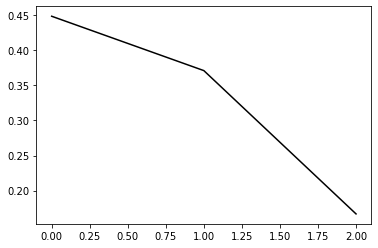

Train data
            0         1         2         3
0    0.971798 -1.744602 -0.912644  2.081540
1    0.971798 -1.725802 -0.971156  2.095433
2    0.971798 -1.668303 -0.768918  1.948067
3    0.971798 -1.654968 -0.621333  1.983792
4    0.971798 -1.599532 -0.106032  1.752625
..        ...       ...       ...       ...
335 -1.261404 -0.239327 -1.019883  1.443393
336 -1.261404 -0.230529 -1.128408  1.666234
337 -1.625310 -0.167256 -1.258490  1.434020
338 -1.625310 -0.261461 -1.261219  1.436832
339 -1.625310 -0.260876 -1.258997  1.433634

[340 rows x 4 columns]
K components
[[-0.46182718 -0.5591836   0.6551106  -0.21180051]
 [-0.33681882 -0.41828449 -0.34570756  0.76946569]
 [ 0.82035696 -0.49709971  0.21379657  0.18492528]]
Transforming train data
            0         1         2
0   -0.512004  2.319602  1.854271
1   -0.563791  2.342656  1.834986
2   -0.432243  2.135297  1.822389
3   -0.350581  2.106187  1.853920
4    0.004960  1.726981  1.893783
..        ...       ...       ...
335 -0.2

<ipython-input-46-56ea6fa93b63>:63: RuntimeWarning: invalid value encountered in sqrt
  mahal = np.sqrt(mahal)


In [ ]:
#@title PCA
# this script is for training the interpreter threshold
PCA_COMPONENTS = 3
GAUSSIAN_MIXTURE_COMPONENTS = 5
ANOMALY_METHOD = "gaussian" # quantile | gaussian | median | score

def fit_pca(dataset, n_components=20, show_plot_variance=False):
    pca = PCA(n_components=n_components)
    print("\t* Fit PCA")
    pca.fit(dataset)

    if show_plot_variance:
        plt.figure()
        plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color='black')
        plt.show()

    return pca

def pca_inverse(dataset_processed, real_dataset, model):
        """
        PCA Inverse transformation
        * model : pca model used for transformation
        ========================
        Return:
            * reconstruction errors (without window)
        """
        dataset_processed = pd.DataFrame(model.inverse_transform(dataset_processed))
        real_dataset = pd.DataFrame(real_dataset[:].values)
        errors = (real_dataset - dataset_processed).to_numpy()

        return errors

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def cov_matrix(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)

        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def mahalanobis_dist(inv_cov_matrix, mean_distr, data):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean

    left = np.dot(diff, inv_covariance_matrix)
    mahal = np.dot(left, diff.T)
    mahal = np.sqrt(mahal)
    return mahal.diagonal()

def print_result(anomalies, y_true):
    print('## RESULTS ##')
    anomalies = (anomalies.to_numpy()*1)
    anomalies = np.where(anomalies == 1, -1, anomalies)
    y_pred = np.where(anomalies == 0, 1, anomalies)
    print(y_pred[100])
    test_sklearn(y_true, y_pred)

# Fit PCA model
print('Fitting PCA model')

pca = fit_pca(dataset=x_train, n_components=PCA_COMPONENTS, show_plot_variance=True)
print("Train data")
print(x_train)
print("K components")
K = pca.components_
print(K)

# Transform train dataset 
print('Transforming train data')
x_train_processed = pd.DataFrame(pca.transform(x_train))
print(x_train_processed)

if ANOMALY_METHOD == 'gaussian':
  gm_nominal = GaussianMixture(n_components=GAUSSIAN_MIXTURE_COMPONENTS, covariance_type='diag', random_state=0).fit(x_train_processed)
  covariance_matrices_nominal = []
  inv_covariance_matrices_nominal = []
  for i in range(GAUSSIAN_MIXTURE_COMPONENTS):
      covariance_matrices_nominal.append(np.diag(gm_nominal.covariances_[i,:]))
      inv_covariance_matrices_nominal.append(np.linalg.inv(np.diag(gm_nominal.covariances_[i,:])))



if ANOMALY_METHOD == 'gaussian':
    print("Calculating threshold for mahalanobis distance")
    mahalanobis_distance_nominal_data = []
    for i in range(GAUSSIAN_MIXTURE_COMPONENTS):
        mahalanobis_distance_nominal_data.append(mahalanobis_dist(inv_covariance_matrices_nominal[i], gm_nominal.means_[i], x_train_processed.values))

    index_nominal = np.argmin(np.array(mahalanobis_distance_nominal_data).T, axis=1)
    #covariance_matrices_to_use = covariance_matrices_nominal 
    mahalanobis_distance_nominal_data = np.min(np.array(mahalanobis_distance_nominal_data).T, axis=1)


In [ ]:
print("FIND THRESHOLD USING NOMINAL DATA INSIDE MAHALANOBIS DECOMPOSITION")
print("\n")
n_features = 4
result = np.array([])
for line in range(0,len(index_nominal)):
  sigma_1, sigma_2, sigma_3 =  covariance_matrices_nominal[index_nominal[line]][0,0], covariance_matrices_nominal[index_nominal[line]][1,1], covariance_matrices_nominal[index_nominal[line]][2,2] 
  mu_1, mu_2, mu_3 = gm_nominal.means_[index_nominal[line]]


  result_a_nominal, result_b_nominal, result_c_nominal = [], [], []

  for i in range(0, n_features):

    # x^2
    a = np.power(x_train.iloc[line,i],2)*(np.power(K[0,i], 2)/sigma_1 + np.power(K[1,i],2)/sigma_2 + np.power(K[2,i],2)/sigma_3)
    result_a_nominal.append(a)

    # -x
    b = -(x_train.iloc[line,i])*(2*mu_1*K[0,i]/sigma_1 + 2*mu_2*K[1,i]/sigma_2 + 2*mu_3*K[2,i]/sigma_3)
    result_b_nominal.append(b)

  # x_*x_
  for i in range(0, n_features):
      for j in range(0, n_features):
          if  i == j or j < i:
            continue 
          else:
          
            c = (x_train.iloc[line,i])*(x_train.iloc[line,j])*(2*K[0,i]*K[0,j]/sigma_1 + 2*K[1,i]*K[1,j]/sigma_2 + 2*K[2,i]*K[2,j]/sigma_3)
            result_c_nominal.append(c)

  d = np.power(mahalanobis_distance_nominal_data[line],2) - np.power(mu_1,2) - np.power(mu_2,2) - np.power(mu_3,2)
  res = result_a_nominal + result_b_nominal + result_c_nominal
  if line == 0:
    result = res
  else:
    result = np.vstack((result, res))

nominal_mean = np.mean(result, axis=0)
nominal_standard_deviation = np.std(result, axis=0)
print(nominal_mean)
print(nominal_standard_deviation)

FIND THRESHOLD USING NOMINAL DATA INSIDE MAHALANOBIS DECOMPOSITION


[  8.12999577   8.36086269   4.72606358   8.85216507 -14.82679816
 -24.29572106 -12.03750778 -18.47065666   3.84407194   0.1283006
  -3.73151514   2.12193182   3.49745081   2.04934478]
[ 9.70357401 11.93669936  5.79774772 34.45129095 23.57178963 32.43089343
 14.00635375 69.10235608  9.91489501  3.72553377 20.1514558   3.07438232
 13.92664118  9.2319641 ]


Fitting PCA model
	* Fit PCA


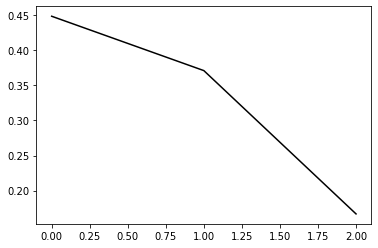

Train data
            0         1         2         3
0    0.971798 -1.744602 -0.912644  2.081540
1    0.971798 -1.725802 -0.971156  2.095433
2    0.971798 -1.668303 -0.768918  1.948067
3    0.971798 -1.654968 -0.621333  1.983792
4    0.971798 -1.599532 -0.106032  1.752625
..        ...       ...       ...       ...
335 -1.261404 -0.239327 -1.019883  1.443393
336 -1.261404 -0.230529 -1.128408  1.666234
337 -1.625310 -0.167256 -1.258490  1.434020
338 -1.625310 -0.261461 -1.261219  1.436832
339 -1.625310 -0.260876 -1.258997  1.433634

[340 rows x 4 columns]
K components
[[-0.46182718 -0.5591836   0.6551106  -0.21180051]
 [-0.33681882 -0.41828449 -0.34570756  0.76946569]
 [ 0.82035696 -0.49709971  0.21379657  0.18492528]]
Transforming train data
            0         1         2
0   -0.512004  2.319602  1.854271
1   -0.563791  2.342656  1.834986
2   -0.432243  2.135297  1.822389
3   -0.350581  2.106187  1.853920
4    0.004960  1.726981  1.893783
..        ...       ...       ...
335 -0.2

<ipython-input-49-134aabe2b2f5>:62: RuntimeWarning: invalid value encountered in sqrt
  mahal = np.sqrt(mahal)


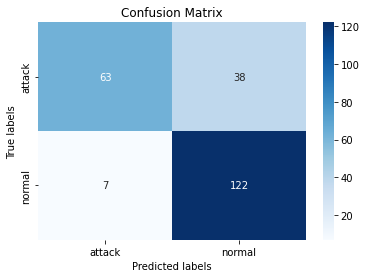

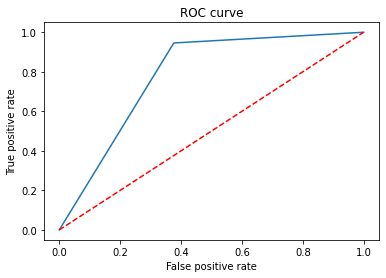

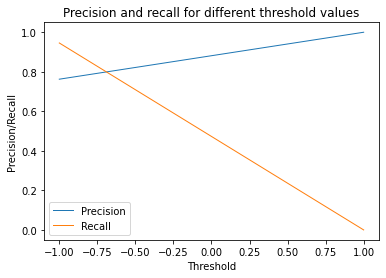

In [ ]:

# this script is for testing
PCA_COMPONENTS = 3
GAUSSIAN_MIXTURE_COMPONENTS = 5
ANOMALY_METHOD = "gaussian" # quantile | gaussian | median | score

def fit_pca(dataset, n_components=20, show_plot_variance=False):
    pca = PCA(n_components=n_components)
    print("\t* Fit PCA")
    pca.fit(dataset)

    if show_plot_variance:
        plt.figure()
        plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color='black')
        plt.show()

    return pca

def pca_inverse(dataset_processed, real_dataset, model):
        """
        PCA Inverse transformation
        * model : pca model used for transformation
        ========================
        Return:
            * reconstruction errors (without window)
        """
        dataset_processed = pd.DataFrame(model.inverse_transform(dataset_processed))
        real_dataset = pd.DataFrame(real_dataset[:].values)
        errors = (real_dataset - dataset_processed).to_numpy()

        return errors

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def cov_matrix(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)

        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def mahalanobis_dist(inv_cov_matrix, mean_distr, data):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean

    left = np.dot(diff, inv_covariance_matrix)
    mahal = np.dot(left, diff.T)
    mahal = np.sqrt(mahal)
    return mahal.diagonal()

def print_result(anomalies, y_true):
    print('## RESULTS ##')
    anomalies = (anomalies.to_numpy()*1)
    anomalies = np.where(anomalies == 1, -1, anomalies)
    y_pred = np.where(anomalies == 0, 1, anomalies)
    print(y_pred[100])
    test_sklearn(y_true, y_pred)

# Fit PCA model
print('Fitting PCA model')

pca = fit_pca(dataset=x_train, n_components=PCA_COMPONENTS, show_plot_variance=True)
print("Train data")
print(x_train)
print("K components")
K = pca.components_
print(K)

# Transform train dataset 
print('Transforming train data')
x_train_processed = pd.DataFrame(pca.transform(x_train))
print(x_train_processed)

if ANOMALY_METHOD == 'gaussian':
  gm = GaussianMixture(n_components=GAUSSIAN_MIXTURE_COMPONENTS, covariance_type='diag', random_state=0).fit(x_train_processed)
  covariance_matrices = []
  inv_covariance_matrices = []
  for i in range(GAUSSIAN_MIXTURE_COMPONENTS):
      covariance_matrices.append(np.diag(gm.covariances_[i,:]))
      inv_covariance_matrices.append(np.linalg.inv(np.diag(gm.covariances_[i,:])))

  # old
  #covariance_matrix, inverse_covariance_matrix = cov_matrix(x_train_processed)


train_pca_errors = pca_inverse(x_train_processed, x_train, model=pca)

# Transform test nominal dataset
print('Transforming test data')
#x_normal_processed = pd.DataFrame(pca.transform(x_normal))
#test_pca_errors = pca_inverse(x_normal_processed, x_normal, model=pca)

# Transform test mixed dataset
x_test_processed = pd.DataFrame(pca.transform(pd.DataFrame(x_test)))
test_pca_errors_full = pca_inverse(x_test_processed, pd.DataFrame(x_test), model=pca)
print("TEST")
print(x_test[100,:])
#print(x_train.iloc[100,:])
print("TEST AFTER PCA")
print(x_test_processed.iloc[100,:])

if ANOMALY_METHOD == 'gaussian':
    print("Calculating threshold for mahalanobis distance")
    mahalanobis_distance = []
    for i in range(GAUSSIAN_MIXTURE_COMPONENTS):
        mahalanobis_distance.append(mahalanobis_dist(inv_covariance_matrices[i], gm.means_[i], x_test_processed.values))
        print("###### info mixtura numero", i)
        print("means\n",gm.means_[i])
        print("cov\n",covariance_matrices[i])
        print(inv_covariance_matrices[i])
        print("result\n", mahalanobis_distance[i][100])
        print("##########\n")
    index = np.argmin(np.array(mahalanobis_distance).T, axis=1)
    print(index)
    #covariance_matrices_to_use = covariance_matrices 
    mahalanobis_distance = np.min(np.array(mahalanobis_distance).T, axis=1)
    print("distance is")
    print(mahalanobis_distance[100])

if ANOMALY_METHOD == 'score':
    print("Calculating threshold for score")
    threshold = np.median(np.sum(np.abs(train_pca_errors), axis=1), axis=0) * 3
elif ANOMALY_METHOD == 'gaussian':
    print("Calculating threshold for gaussian")
    threshold = np.median(np.sum(np.abs(train_pca_errors), axis=1), axis=0) *11

else:
    print("Calculating threshold for median")
    threshold = np.median(np.abs(train_pca_errors), axis=0)


########## DETECT ANOMALIES ##########

# 1. anomalies with quantiles
if ANOMALY_METHOD == 'quantile':
    print('Calculating bound for quantile')
    q1, q2 = np.quantile(train_pca_errors, [0.05, 0.95], axis=0)
    pc_iqr = q2 - q1
    pc_lower_bound = q1 - (2 * pc_iqr)
    pc_upper_bound = q2 + (2 * pc_iqr)

    print('Detecting anomalies using quantiles')
    anomalies = ((test_pca_errors_full > pc_upper_bound) | (test_pca_errors_full < pc_lower_bound)) == True
    anomalies = pd.DataFrame(anomalies)
    #Return true if along the axis there is at least a true
    anomalies = anomalies.any(axis='columns')
    print_result(anomalies, y_true)

# 2. anomalies with median threshold
elif ANOMALY_METHOD == 'median':
    print('Detecting anomalies using median')
    anomalies = (np.abs(test_pca_errors_full) > threshold) == True
    anomalies = pd.DataFrame(anomalies)
    anomalies = anomalies.any(axis='columns')
    print_result(anomalies, y_true)

# 3. anomalies with anomaly score and threshold
elif ANOMALY_METHOD == 'score':
    print('Detecting anomalies using score')
    anomaly_score = pd.DataFrame(np.sum(np.abs(test_pca_errors_full), axis=1), columns=['score'])
    anomalies = (anomaly_score > threshold) == True
    print_result(anomalies, y_true)
   
# 4. anomalies with mahalanobis distance
elif ANOMALY_METHOD == 'gaussian':
    print('Detecting anomalies using gaussian')
    mahalanobis_anomaly_score = pd.DataFrame(mahalanobis_distance, columns=['score'])
    anomalies = (mahalanobis_anomaly_score > threshold) == True
    print_result(anomalies, y_true)

In [ ]:
print("MAHALANOBIS DECOMPOSITION")
print("\n")
n_features = 4
line = 140
sigma_1, sigma_2, sigma_3 =  covariance_matrices[index[line]][0,0], covariance_matrices[index[line]][1,1], covariance_matrices[index[line]][2,2] 
mu_1, mu_2, mu_3 = gm.means_[index[line]]


result_a, result_b, result_c = [], [], []

for i in range(0, n_features):

  # x^2
  a = np.power(x_test[line,i],2)*(np.power(K[0,i], 2)/sigma_1 + np.power(K[1,i],2)/sigma_2 + np.power(K[2,i],2)/sigma_3)
  result_a.append(a)

  # -x
  b = -(x_test[line,i])*(2*mu_1*K[0,i]/sigma_1 + 2*mu_2*K[1,i]/sigma_2 + 2*mu_3*K[2,i]/sigma_3)
  result_b.append(b)

# x_*x_
for i in range(0, n_features):
    for j in range(0, n_features):
        if  i == j or j < i:
          continue 
        else:
          
          c = (x_test[line,i])*(x_test[line,j])*(2*K[0,i]*K[0,j]/sigma_1 + 2*K[1,i]*K[1,j]/sigma_2 + 2*K[2,i]*K[2,j]/sigma_3)
          result_c.append(c)

d = np.power(mahalanobis_distance[line],2) - np.power(mu_1,2) - np.power(mu_2,2) - np.power(mu_3,2)

final_result = result_a + result_b + result_c

for j in range(0,len(final_result)):
  if final_result[j] > nominal_mean[j]:
    print("The variable number", j +1, "caused the anomaly!!")

print("\n")
print("Contribute for the line", line+1, ":")
print("x1^2 - x2^2 - x3^2 - x4^2")
print(result_a)
print("\n")
print("x1 - x2 - x3 - x4")
print(result_b)
print("\n")
print("x1 x2 - x1 x3 - x1 x4 - x2 x3 - x2 x4 - x3 x4")
print(result_c)
print("\n")
print("distance")
print(d)
print("-------------------------------------------------")
sx = sum(result_a) + sum(result_b) + sum(result_c) 
print(sx, "---", d)



MAHALANOBIS DECOMPOSITION


The variable number 4 caused the anomaly!!
The variable number 5 caused the anomaly!!
The variable number 6 caused the anomaly!!
The variable number 7 caused the anomaly!!
The variable number 11 caused the anomaly!!
The variable number 14 caused the anomaly!!


Contribute for the line 141 :
x1^2 - x2^2 - x3^2 - x4^2
[0.002196104282187567, 0.36852173286333867, 0.22720295203060326, 340.83840098506346]


x1 - x2 - x3 - x4
[0.0658485898436691, 3.566804419599815, -0.4132277125747382, -107.7154173109028]


x1 x2 - x1 x3 - x1 x4 - x2 x3 - x2 x4 - x3 x4
[-0.0036094869915305867, 0.0007791503364421645, 0.17838582884391493, 0.2323795995184279, -10.690481434188866, 10.787548116360082]


distance
245.5275316855012
-------------------------------------------------
237.44533153408403 --- 245.5275316855012


In [ ]:
#@title Local Outlier Factor
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
classifier = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination='auto')
classifier.fit(x_train)
y_pred = classifier.predict(x_test)
test_sklearn(y_true, y_pred)

In [ ]:
#@title Elliptic Envelope
#https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope
classifier = EllipticEnvelope(contamination=0.07)
classifier.fit(x_train)
y_pred = classifier.predict(x_test)
test_sklearn(y_true, y_pred)

In [ ]:
#@title Isolation Forest
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
#classifier = IsolationForest(max_samples=15, n_estimators=100, n_jobs=4, contamination=0.1)
classifier = IsolationForest(contamination=0.1)

classifier.fit(x_train)
y_pred = classifier.predict(x_test)
test_sklearn(y_true, y_pred)

In [ ]:
#@title  OneClass SVM
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM
#tune the OneClass SVM on the 30% of test samples of normal type: best tuning on validation is obtained with gamma = 10**(-4), nu = 0.01


Gamma = 10**(-4)
Nu = 0.01

classifier = svm.OneClassSVM(nu=Nu, kernel="rbf", gamma=Gamma)
classifier.fit(x_train)

y_pred = classifier.predict(x_test)
test_sklearn(y_true, y_pred)